In [32]:
# Julia 1.8.4
using Pkg
Pkg.activate(".")
Pkg.instantiate()
# Pkg.add("CUDA")
# Pkg.add("Glob")
# Pkg.add("Flux")
# Pkg.add("NIfTI")
# Pkg.add("Images")
# Pkg.add("FastAI")
# Pkg.add("Metalhead")
# Pkg.add("FastVision")
# Pkg.add("CairoMakie")
# Pkg.add("StaticArrays")
# Pkg.add("MLDataPattern")
# Pkg.add("BenchmarkTools")
# Pkg.add("ChainRulesCore")
# Pkg.add("BSON")
# Pkg.add("DataFrames")
# Pkg.add("CSV")
# Pkg.add(url = "https://github.com/Dale-Black/ComputerVisionMetrics.jl")
# Pkg.add(url="https://github.com/Dale-Black/DistanceTransforms.jl", rev="wenbo")

  Activating project at `c:\Users\wenbl13\Desktop\Wenbo_Timing`


In [33]:
using CUDA
using Glob
using Dates
using NIfTI
using Images
using Statistics
using StaticArrays
using MLDataPattern
using BenchmarkTools
using ChainRulesCore
using DistanceTransforms
using DataFrames
using CSV
using FastAI, FastVision, Flux, Metalhead
import CairoMakie; CairoMakie.activate!(type="png")
using ComputerVisionMetrics

In [34]:
# @load "test/Dice_50.bson" model1

In [35]:
# model1

In [36]:
ks = DistanceTransforms.get_GPU_kernels(Wenbo())
size(ks)

GPU threads = 768.


(11,)

# Load and prepare data

In [37]:
data_dir = raw"C:\Users\wenbl13\Desktop\Ashwin-Timing\distance-transforms\Task02_Heart"

"C:\\Users\\wenbl13\\Desktop\\Ashwin-Timing\\distance-transforms\\Task02_Heart"

In [38]:
function loadfn_label(p)
    a = NIfTI.niread(string(p)).raw
    convert_a = convert(Array{UInt8}, a)
    convert_a = convert_a .+ 1
    return convert_a
end

function loadfn_image(p)
    a = NIfTI.niread(string(p)).raw
    convert_a = convert(Array{Float32}, a)
    convert_a = convert_a / max(convert_a...)
    return convert_a
end

loadfn_image (generic function with 1 method)

In [39]:
images(dir) = mapobs(loadfn_image, Glob.glob("*.nii*", dir))
masks(dir) =  mapobs(loadfn_label, Glob.glob("*.nii*", dir))
pre_data = (
    images(joinpath(data_dir, "imagesTr")),
    masks(joinpath(data_dir, "labelsTr")),
);

In [40]:
image_size = (96, 96, 96)

(96, 96, 96)

In [41]:
function presize(files)
    container_images = Array{Float32,4}(undef, image_size..., numobs(files))
    container_masks = Array{Int64,4}(undef, image_size..., numobs(files))
    for i in 1:numobs(files)
        image, mask = FastAI.getobs(files, i)
        img = imresize(image, image_size)
        msk = round.(imresize(mask, image_size))
        container_images[:, :, :, i] = img
        container_masks[:, :, :, i] = msk
    end
    return container_images, container_masks
end

presize (generic function with 1 method)

In [42]:
img_container, mask_container = presize(pre_data)
data_resized = (img_container,mask_container);

In [43]:
a, b = FastVision.imagedatasetstats(img_container, Gray{N0f8}) 
means, stds = SVector{1, Float32}(a[1]), SVector{1, Float32}(b[1])

Progress:  10%|█████                                    |  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


(Float32[0.09098037], Float32[0.13637377])

In [44]:
task = SupervisedTask(
    (FastVision.Image{3}(), Mask{3}(1:2)),
    (
        ProjectiveTransforms((image_size)),
        ImagePreprocessing(means = means, stds = stds, C = Gray{N0f8}),
        FastAI.OneHot()
    )
)

SupervisedTask(Image{3} -> Mask{3, Int64})

In [45]:
train_files, val_files = MLDataPattern.splitobs(data_resized, 0.8);

In [46]:
batch_size = 4
tdl, vdl = FastAI.taskdataloaders(train_files, val_files, task, batch_size);

In [47]:
# for (xs, ys) in tdl
#     println(size(xs))
#     println(typeof(xs))
#     println(size(ys))
#     println(typeof(ys))
#     println(minimum(ys))
#     println(maximum(ys))
#     println(typeof(maximum(ys)))
#     break
# end

Move data to gpu and pre-DT ground truth masks

In [49]:
traindl = Tuple{Tuple{CuArray{Float32, 5, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 5, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 5, CUDA.Mem.DeviceBuffer}}[] 
validdl = Tuple{Tuple{CuArray{Float32, 5, CUDA.Mem.DeviceBuffer}, CuArray{Float32, 5, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 5, CUDA.Mem.DeviceBuffer}}[] 
for (xs, ys) in vdl
    # DT
    ŷ_cpu = round.(ys[:,:,:,2:end,:])
    ŷ_dtm = similar(ŷ_cpu)
    s = size(ŷ_cpu)
    for batch = 1 : s[5]
        for channel = 1: s[4]
            ŷ_dtm[:,:,:, channel, batch] = DistanceTransforms.transform(ŷ_cpu[:,:,:, channel, batch], Maurer()) # Maurer
        end
    end
    ys_dt_gpu = ŷ_dtm |> gpu

    ys_gpu = CuArray(ys[:,:,:,2:end,:])
    # ys_dt_gpu = DistanceTransforms.transform(true, ys_gpu, Wenbo(), ks)
    xs_gpu = xs |> gpu
    push!(validdl, ((xs_gpu,ys_gpu), ys_dt_gpu))
end

for (xs, ys) in tdl
    # DT
    ŷ_cpu = round.(ys[:,:,:,2:end,:])
    ŷ_dtm = similar(ŷ_cpu)
    s = size(ŷ_cpu)
    for batch = 1 : s[5]
        for channel = 1: s[4]
            ŷ_dtm[:,:,:, channel, batch] = DistanceTransforms.transform(ŷ_cpu[:,:,:, channel, batch], Maurer()) # Maurer
        end
    end
    ys_dt_gpu = ŷ_dtm |> gpu

    ys_gpu = CuArray(ys[:,:,:,2:end,:])
    # ys_dt_gpu = DistanceTransforms.transform(true, ys_gpu, Wenbo(), ks)
    xs_gpu = xs |> gpu
    push!(traindl, ((xs_gpu,ys_gpu), ys_dt_gpu))
end

┌ Warning: Number of observations less than batch-size, decreasing the batch-size to 4
└ @ MLUtils C:\Users\wenbl13\.julia\packages\MLUtils\Th9Y3\src\batchview.jl:95


# Model

In [18]:
conv = (stride, in, out) -> Conv((3, 3, 3), in=>out, stride=stride, pad=SamePad())
tran = (stride, in, out) -> ConvTranspose((3, 3, 3), in=>out, stride=stride, pad=SamePad())

conv1 = (in, out) -> Chain(conv(1, in, out), BatchNorm(out, leakyrelu))
conv2 = (in, out) -> Chain(conv(2, in, out), BatchNorm(out, leakyrelu))
conv3 = (in, out) -> Chain(conv(1, in, out), x -> softmax(x; dims = 4))
# conv3 = (in, out) -> Chain(conv(1, in, out), BatchNorm(out, sigmoid))
tran2 = (in, out) -> Chain(tran(2, in, out), BatchNorm(out, leakyrelu))



function unet3D_new(in_chs, lbl_chs)
    # Contracting layers
    l1 = Chain(conv1(in_chs, 8))
    l2 = Chain(l1, conv2(8, 16), conv1(16, 16))
    l3 = Chain(l2, conv2(16, 32), conv1(32, 32))
    l4 = Chain(l3, conv2(32, 64), conv1(64, 64))
    l5 = Chain(l4, conv2(64, 128), conv1(128, 128))

    # Expanding layers
    l6 = Chain(l5, tran2(128, 64))
    l7 = Chain(Parallel(FastVision.Models.catchannels,l4,l6), conv1(128, 64), tran2(64, 32))
    l8 = Chain(Parallel(FastVision.Models.catchannels,l3,l7), conv1(64, 32), tran2(32, 16))
    l9 = Chain(Parallel(FastVision.Models.catchannels,l2,l8), conv1(32, 16), tran2(16, 8))
    l10 = Chain(l9, conv3(8, lbl_chs))
end

unet3D_new (generic function with 1 method)

In [19]:
# model_temp = unet3D_new(1, 2)
# input_temp = rand(Float32,96,96,96,1,4)
# truth_temp = round.(rand(Float32,96,96,96,1,4))
# output_temp = model_temp(input_temp);

# Loss

In [20]:
function dice_loss(ŷ, y; ϵ=1.0f-5)
    loss_dice = 1.0f0 - (muladd(2.0f0, sum(ŷ .* y), ϵ) / (sum(ŷ .^ 2) + sum(y .^ 2) + ϵ))
    return loss_dice
end

dice_loss (generic function with 1 method)

In [50]:
function dice_hausdorff_loss(ŷ, y, y_dtm, epoch_idx; ϵ=1.0f-5)
    # ŷ_dtm = 0
    ŷ_dtm = similar(ŷ)
    ignore_derivatives() do
        # Distance transform    d1 * d2 * d3 * channel * batch
        # ŷ_dtm = DistanceTransforms.transform(true, ŷ, Wenbo(), ks)
        ŷ_cpu = round.(ŷ) |> cpu
        s = size(ŷ)
        for batch = 1 : s[5]
            for channel = 1: s[4]
                ŷ_dtm[:,:,:, channel, batch] = DistanceTransforms.transform(ŷ_cpu[:,:,:, channel, batch], Maurer()) # Maurer
                # ŷ_dtm[:,:,:, channel, batch] = DistanceTransforms.transform(ŷ_cpu[:,:,:, channel, batch], Wenbo(), 16) # Wenbo
            end
        end
        ŷ_dtm = ŷ_dtm |> gpu
    end
    loss_hd = mean(((ŷ .- y) .^ 2) .* (ŷ_dtm .^2 .+ y_dtm .^2))
    loss_dice = 1.0f0 - (muladd(2.0f0, sum(ŷ .* y), ϵ) / (sum(ŷ .^ 2) + sum(y .^ 2) + ϵ))
    α = epoch_idx * 1.0f-3
    loss = α * loss_hd + (1.0f0 - α) * loss_dice
    return loss
end

dice_hausdorff_loss (generic function with 1 method)

# Custom Loops

In [24]:
function train_1_epoch_with_DICE!(epoch_idx, model, model_ps, train_dl, valid_dl, optimizer)
    flush(stdout)
    println("Epoch #$epoch_idx...\n\t")
    times_per_step = [] 
    # Epoch start
    time_per_epoch = 0
    step_ct = 0
    t1 = Dates.Time(now())
    for (img_mask, mask_dtm) in train_dl
      img, mask = img_mask 
      # 96 * 96 * 96 * 1 * batch_size
      t2 = Dates.Time(now())
      curr_step_time = @timed begin
        # Step start
        gs = gradient(model_ps) do
          pred_mask = model(img)
          training_loss = dice_loss(pred_mask[:,:,:,2:end,:], mask)
          return training_loss
        end
        Flux.update!(optimizer, model_ps, gs)
      end
      # Step finished
      push!(times_per_step, (curr_step_time.time * 10^9)+(t2-t1).value)
      time_per_epoch += curr_step_time.time * 10^9 + (t2-t1).value # t2 - t1 is the loading time from dataloader
      step_ct += 1
      t1 = Dates.Time(now())
    end
    # Epoch finished
    # Train set loss
    train_losses = []
    train_dice_metrics = []
    train_hd_metrics = []
    for (img_mask, mask_dtm) in train_dl
      img, mask = img_mask 
      pred_mask = model(img)
      training_loss = dice_loss(pred_mask[:,:,:,2:end,:], mask)
      push!(train_losses, training_loss)
      pred_mask_bi_1 = pred_mask[:,:,:,2,1] .> 0.5
      mask_bi_1 = mask[:,:,:,1,1] .> 0.5
      pred_mask_bi = pred_mask_bi_1 |> cpu
      mask_bi = mask_bi_1 |> cpu
      dice_m = ComputerVisionMetrics.dice(pred_mask_bi, mask_bi)
      hd_m = ComputerVisionMetrics.hausdorff(pred_mask_bi, mask_bi)
      push!(train_dice_metrics, dice_m)
      push!(train_hd_metrics, hd_m)
    end
    # Valid set loss
    valid_losses = []
    valid_dice_metrics = []
    valid_hd_metrics = []
    for (img_mask, mask_dtm) in valid_dl
      img, mask = img_mask 
      pred_mask = model(img)
      valid_loss = dice_loss(pred_mask[:,:,:,2:end,:], mask)
      push!(valid_losses, valid_loss)
      pred_mask_bi_1 = pred_mask[:,:,:,2,1] .> 0.5
      mask_bi_1 = mask[:,:,:,1,1] .> 0.5
      pred_mask_bi = pred_mask_bi_1 |> cpu
      mask_bi = mask_bi_1 |> cpu
      dice_m2 = ComputerVisionMetrics.dice(pred_mask_bi, mask_bi)
      hd_m2 = ComputerVisionMetrics.hausdorff(pred_mask_bi, mask_bi)
      push!(valid_dice_metrics, dice_m2)
      push!(valid_hd_metrics, hd_m2)
    end
    println("\tFinished $step_ct steps --> Train loss = $(mean(train_losses)), Valid loss = $(mean(valid_losses)), 
    Dice = $(mean(valid_dice_metrics)), HD = $(mean(valid_hd_metrics))")
    return time_per_epoch, times_per_step, mean(train_losses), mean(valid_losses), mean(train_dice_metrics), 
    mean(train_hd_metrics), mean([mean(train_dice_metrics), mean(valid_dice_metrics)]), mean(valid_dice_metrics), 
    mean(valid_hd_metrics), mean([mean(train_hd_metrics), mean(valid_hd_metrics)])
  end

train_1_epoch_with_DICE! (generic function with 1 method)

In [22]:
function train_1_epoch_with_DICE_and_HD!(epoch_idx, model, model_ps, train_dl, valid_dl, optimizer)
    ep_idx = Float32(epoch_idx)
    flush(stdout)
    println("Epoch #$epoch_idx...")
    times_per_step = [] 
    # Epoch start (4 outputs)
    time_per_epoch = 0
    step_ct = 0
    t1 = Dates.Time(now())
    for (img_mask, mask_dtm) in train_dl
      img, mask = img_mask 
      # Step start
      gs = gradient(model_ps) do
        pred_mask = model(img)
        training_loss = dice_hausdorff_loss(pred_mask[:,:,:,2:end,:], mask, mask_dtm, ep_idx)
        return training_loss
      end
      Flux.update!(optimizer, model_ps, gs)
      # Step finished
      t2 = Dates.Time(now())
      curr_step_time = (t2-t1).value
      push!(times_per_step, curr_step_time)
      time_per_epoch += curr_step_time
      step_ct += 1
      t1 = Dates.Time(now())
    end
    # Epoch finished
    # Train set loss (4 outputs)
    train_losses = []
    train_dice_metrics = []
    train_hd_metrics = []
    valid_losses = []
    valid_dice_metrics = []
    valid_hd_metrics = []
    for (img_mask, mask_dtm) in train_dl
      # Run model
      img, mask = img_mask 
      pred_mask = model(img)
      # Loss
      training_loss = dice_hausdorff_loss(pred_mask[:,:,:,2:end,:], mask, mask_dtm, ep_idx)
      push!(train_losses, training_loss)
      # # Metrics
      # pred_mask_bi_1 = pred_mask[:,:,:,2,1] .> 0.5
      # mask_bi_1 = mask[:,:,:,1,1] .> 0.5
      # pred_mask_bi = pred_mask_bi_1 |> cpu
      # mask_bi = mask_bi_1 |> cpu
      # dice_m = ComputerVisionMetrics.dice(pred_mask_bi, mask_bi)
      # hd_m = ComputerVisionMetrics.hausdorff(pred_mask_bi, mask_bi)
      # push!(train_dice_metrics, dice_m)
      # push!(train_hd_metrics, hd_m)
    end
    # Valid set loss (1 outputs)
    for (img_mask, mask_dtm) in valid_dl
      # Run model
      img, mask = img_mask 
      pred_mask = model(img)
      # Loss
      valid_loss = dice_hausdorff_loss(pred_mask[:,:,:,2:end,:], mask, mask_dtm, ep_idx)
      push!(valid_losses, valid_loss)
      # # Metrics
      # pred_mask_bi_1 = pred_mask[:,:,:,2,1] .> 0.5
      # mask_bi_1 = mask[:,:,:,1,1] .> 0.5
      # pred_mask_bi = pred_mask_bi_1 |> cpu
      # mask_bi = mask_bi_1 |> cpu
      # dice_m2 = ComputerVisionMetrics.dice(pred_mask_bi, mask_bi)
      # hd_m2 = ComputerVisionMetrics.hausdorff(pred_mask_bi, mask_bi)
      # push!(valid_dice_metrics, dice_m2)
      # push!(valid_hd_metrics, hd_m2)
    end
    # println("\tFinished $step_ct steps --> Train loss = $(mean(train_losses)), Valid loss = $(mean(valid_losses)), 
    # Dice = $(mean(valid_dice_metrics)), HD = $(mean(valid_hd_metrics))")
    println("\tFinished $step_ct steps --> Train loss = $(mean(train_losses)), Valid loss = $(mean(valid_losses))")
    # return time_per_epoch, times_per_step, mean(train_losses), mean(valid_losses), mean(train_dice_metrics), 
    # mean(train_hd_metrics), mean([mean(train_dice_metrics), mean(valid_dice_metrics)]), mean(valid_dice_metrics), 
    # mean(valid_hd_metrics), mean([mean(train_hd_metrics), mean(valid_hd_metrics)])
    return time_per_epoch, times_per_step, mean(train_losses), mean(valid_losses)
  end

train_1_epoch_with_DICE_and_HD! (generic function with 1 method)

# Train, Loss = Dice

In [44]:
num_epochs_dice = 250
epoch_times_dice = []
step_times_dice = []
epoch_train_losses_dice = []
epoch_valid_losses_dice = []
train_dice_metric_epoch_dice = []
valid_dice_metric_epoch_dice = []
train_hd_metric_epoch_dice = []
valid_hd_metric_epoch_dice = []
all_dice_metric_epoch_dice = []
all_hd_metric_epoch_dice = []
model1 = unet3D_new(1, 2) |> gpu
model_ps = Flux.params(model1)
optimizer = Adam() 
for epoch_idx = 1:num_epochs_dice
    curr_time_epoch, curr_times_step, curr_train_losses, curr_valid_losses, curr_train_dice, curr_train_hd, curr_all_dice, 
    curr_valid_dice, curr_valid_hd, curr_all_hd = train_1_epoch_with_DICE!(epoch_idx, model1, model_ps, traindl, validdl, optimizer)
    # Record data
    push!(epoch_times_dice, curr_time_epoch)
    for i in curr_times_step
        push!(step_times_dice, i)
    end
    push!(epoch_train_losses_dice, curr_train_losses)
    push!(epoch_valid_losses_dice, curr_valid_losses)
    push!(train_dice_metric_epoch_dice, curr_train_dice)
    push!(valid_dice_metric_epoch_dice, curr_valid_dice)
    push!(train_hd_metric_epoch_dice, curr_train_hd)
    push!(valid_hd_metric_epoch_dice, curr_valid_hd)
    push!(all_dice_metric_epoch_dice, curr_all_dice)
    push!(all_hd_metric_epoch_dice, curr_all_hd)
    if epoch_idx % 25 == 0
        #save model
        savetaskmodel(string("savedmodels/Dice_", epoch_idx, ".jld2"), task, model1, force = true) # saving as cpu model
    end
end

Epoch #1...
	


	Finished 4 steps --> Train loss = 0.9769528, Valid loss = 0.9785426, 
    Dice = 0.017548743477216654, HD = 77.31106001084191


Epoch #2...
	


	Finished 4 steps --> Train loss = 0.9751758, Valid loss = 0.9768351, 
    Dice = 0.019328825185975416, HD = 76.08547824650904


Epoch #3...
	


	Finished 4 steps --> Train loss = 0.96870035, Valid loss = 0.9708064, 
    Dice = 0.0253198032445012, HD = 68.65857557508748


Epoch #4...
	


	Finished 4 steps --> Train loss = 0.9430659, Valid loss = 0.946258, 
    Dice = 0.18997452119893504, HD = 46.06517122512408


Epoch #5...
	


	Finished 4 steps --> Train loss = 0.90940833, Valid loss = 0.9117977, 
    Dice = 0.37679769894535, HD = 25.03996805109783


Epoch #6...
	


	Finished 4 steps --> Train loss = 0.84028673, Valid loss = 0.8469685, 
    Dice = 0.4156645874863353, HD = 21.6794833886788


Epoch #7...
	


	Finished 4 steps --> Train loss = 0.81525964, Valid loss = 0.81897163, 
    Dice = 0.5838128116609129, HD = 16.64331697709324


Epoch #8...
	


	Finished 4 steps --> Train loss = 0.6065345, Valid loss = 0.60607266, 
    Dice = 0.47977643771142814, HD = 17.60681686165901


Epoch #9...
	


	Finished 4 steps --> Train loss = 0.73756444, Valid loss = 0.717815, 
    Dice = 0.22666316066263476, HD = 24.351591323771842


Epoch #10...
	


	Finished 4 steps --> Train loss = 0.34745044, Valid loss = 0.32159436, 
    Dice = 0.7362022076467765, HD = 13.0


Epoch #11...
	


	Finished 4 steps --> Train loss = 0.24258061, Valid loss = 0.25678408, 
    Dice = 0.7237578429710022, HD = 12.68857754044952


Epoch #12...
	


	Finished 4 steps --> Train loss = 0.25286177, Valid loss = 0.25855803, 
    Dice = 0.7043803653973145, HD = 7.0710678118654755


Epoch #13...
	


	Finished 4 steps --> Train loss = 0.37423182, Valid loss = 0.37259406, 
    Dice = 0.5866885784716516, HD = 18.439088914585774


Epoch #14...
	


	Finished 4 steps --> Train loss = 0.15974866, Valid loss = 0.18409622, 
    Dice = 0.7279800809212574, HD = 10.816653826391969


Epoch #15...
	


	Finished 4 steps --> Train loss = 0.16537148, Valid loss = 0.16561985, 
    Dice = 0.8045867176301958, HD = 9.0


Epoch #16...
	


	Finished 4 steps --> Train loss = 0.1406667, Valid loss = 0.16823316, 
    Dice = 0.8152828802351212, HD = 8.774964387392123


Epoch #17...
	


	Finished 4 steps --> Train loss = 0.22969383, Valid loss = 0.25305933, 
    Dice = 0.6226452508427524, HD = 11.445523142259598


Epoch #18...
	


	Finished 4 steps --> Train loss = 0.1652275, Valid loss = 0.19984972, 
    Dice = 0.7574365175332527, HD = 7.0


Epoch #19...
	


	Finished 4 steps --> Train loss = 0.13614571, Valid loss = 0.17256129, 
    Dice = 0.8056382145653876, HD = 8.774964387392123


Epoch #20...
	


	Finished 4 steps --> Train loss = 0.11041401, Valid loss = 0.15855408, 
    Dice = 0.8151510852603207, HD = 7.54983443527075


Epoch #21...
	


	Finished 4 steps --> Train loss = 0.1414762, Valid loss = 0.18268275, 
    Dice = 0.6661085063630274, HD = 8.774964387392123


Epoch #22...
	


	Finished 4 steps --> Train loss = 0.10531263, Valid loss = 0.1492899, 
    Dice = 0.823580282502162, HD = 7.54983443527075


Epoch #23...
	


	Finished 4 steps --> Train loss = 0.10434522, Valid loss = 0.15105891, 
    Dice = 0.8111759287688056, HD = 8.06225774829855


Epoch #24...
	


	Finished 4 steps --> Train loss = 0.10916823, Valid loss = 0.15391928, 
    Dice = 0.8074500136948781, HD = 7.54983443527075


Epoch #25...
	


	Finished 4 steps --> Train loss = 0.097144976, Valid loss = 0.15271902, 
    Dice = 0.8040816326530612, HD = 8.06225774829855


Epoch #26...
	


	Finished 4 steps --> Train loss = 0.08659837, Valid loss = 0.14190227, 
    Dice = 0.7928907168037603, HD = 8.06225774829855


Epoch #27...
	


	Finished 4 steps --> Train loss = 0.08318703, Valid loss = 0.13775462, 
    Dice = 0.8218322427126711, HD = 7.54983443527075


Epoch #28...
	


	Finished 4 steps --> Train loss = 0.120189235, Valid loss = 0.1652506, 
    Dice = 0.7797120857047205, HD = 8.06225774829855


Epoch #29...
	


	Finished 4 steps --> Train loss = 0.091726795, Valid loss = 0.13001508, 
    Dice = 0.8232206268334106, HD = 7.681145747868608


Epoch #30...
	


	Finished 4 steps --> Train loss = 0.09467064, Valid loss = 0.1647656, 
    Dice = 0.7894073139974779, HD = 8.306623862918075


Epoch #31...
	


	Finished 4 steps --> Train loss = 0.08937852, Valid loss = 0.15792477, 
    Dice = 0.8074980058495081, HD = 8.306623862918075


Epoch #32...
	


	Finished 4 steps --> Train loss = 0.08539282, Valid loss = 0.13514286, 
    Dice = 0.8301939836941242, HD = 7.54983443527075


Epoch #33...
	


	Finished 4 steps --> Train loss = 0.08068851, Valid loss = 0.1430198, 
    Dice = 0.7977110157367668, HD = 8.06225774829855


Epoch #34...
	


	Finished 4 steps --> Train loss = 0.07562497, Valid loss = 0.120670974, 
    Dice = 0.8379724582478758, HD = 7.54983443527075


Epoch #35...
	


	Finished 4 steps --> Train loss = 0.10353951, Valid loss = 0.15874678, 
    Dice = 0.7828636585763153, HD = 8.06225774829855


Epoch #36...
	


	Finished 4 steps --> Train loss = 0.07374002, Valid loss = 0.12772101, 
    Dice = 0.8052672347017815, HD = 8.06225774829855


Epoch #37...
	


	Finished 4 steps --> Train loss = 0.0650264, Valid loss = 0.13487172, 
    Dice = 0.801056338028169, HD = 8.06225774829855


Epoch #38...
	


	Finished 4 steps --> Train loss = 0.0884376, Valid loss = 0.14360231, 
    Dice = 0.8260197775030902, HD = 8.06225774829855


Epoch #39...
	


	Finished 4 steps --> Train loss = 0.0818557, Valid loss = 0.13416588, 
    Dice = 0.8067333650944895, HD = 8.12403840463596


Epoch #40...
	


	Finished 4 steps --> Train loss = 0.06871386, Valid loss = 0.136105, 
    Dice = 0.7899461400359067, HD = 8.306623862918075


Epoch #41...
	


	Finished 4 steps --> Train loss = 0.0678837, Valid loss = 0.13601571, 
    Dice = 0.8288995493531036, HD = 8.06225774829855


Epoch #42...
	


	Finished 4 steps --> Train loss = 0.06495936, Valid loss = 0.12306303, 
    Dice = 0.8251094009355666, HD = 8.06225774829855


Epoch #43...
	


	Finished 4 steps --> Train loss = 0.07396589, Valid loss = 0.1414969, 
    Dice = 0.7948555096856145, HD = 8.12403840463596


Epoch #44...
	


	Finished 4 steps --> Train loss = 0.06788431, Valid loss = 0.13377959, 
    Dice = 0.8359050445103857, HD = 8.06225774829855


Epoch #45...
	


	Finished 4 steps --> Train loss = 0.062573165, Valid loss = 0.12951672, 
    Dice = 0.8116408306522375, HD = 8.306623862918075


Epoch #46...
	


	Finished 4 steps --> Train loss = 0.05882974, Valid loss = 0.13054836, 
    Dice = 0.8228606544784145, HD = 8.06225774829855


Epoch #47...
	


	Finished 4 steps --> Train loss = 0.053747147, Valid loss = 0.12651646, 
    Dice = 0.8403118683222639, HD = 7.54983443527075


Epoch #48...
	


	Finished 4 steps --> Train loss = 0.061848834, Valid loss = 0.13414204, 
    Dice = 0.8039246223329699, HD = 8.06225774829855


Epoch #49...
	


	Finished 4 steps --> Train loss = 0.08737902, Valid loss = 0.15008438, 
    Dice = 0.8085867620751341, HD = 8.246211251235321


Epoch #50...
	


	Finished 4 steps --> Train loss = 0.07270475, Valid loss = 0.13641512, 
    Dice = 0.7974317817014446, HD = 8.12403840463596

Epoch #51...
	


	Finished 4 steps --> Train loss = 0.049626708, Valid loss = 0.13530064, 
    Dice = 0.8327319959590128, HD = 8.306623862918075


Epoch #52...
	


	Finished 4 steps --> Train loss = 0.14462648, Valid loss = 0.22099274, 
    Dice = 0.747361174850849, HD = 7.280109889280518


Epoch #53...
	


	Finished 4 steps --> Train loss = 0.04730709, Valid loss = 0.12849844, 
    Dice = 0.8362168396770473, HD = 8.06225774829855


Epoch #54...
	


	Finished 4 steps --> Train loss = 0.05531004, Valid loss = 0.12538481, 
    Dice = 0.8279767370676462, HD = 7.681145747868608


Epoch #55...
	


	Finished 4 steps --> Train loss = 0.0480697, Valid loss = 0.123579085, 
    Dice = 0.8255456276548997, HD = 7.54983443527075


Epoch #56...
	


	Finished 4 steps --> Train loss = 0.07139346, Valid loss = 0.13622922, 
    Dice = 0.8330170777988615, HD = 8.06225774829855


Epoch #57...
	


	Finished 4 steps --> Train loss = 0.04401505, Valid loss = 0.114362, 
    Dice = 0.844009922661608, HD = 5.196152422706632


Epoch #58...
	


	Finished 4 steps --> Train loss = 0.055382907, Valid loss = 0.1326701, 
    Dice = 0.8237844533911428, HD = 8.12403840463596


Epoch #59...
	


	Finished 4 steps --> Train loss = 0.052633062, Valid loss = 0.12399274, 
    Dice = 0.844964730601831, HD = 8.06225774829855


Epoch #60...
	


	Finished 4 steps --> Train loss = 0.04186052, Valid loss = 0.11845827, 
    Dice = 0.836937463471654, HD = 8.12403840463596


Epoch #61...
	


	Finished 4 steps --> Train loss = 0.043164, Valid loss = 0.12421566, 
    Dice = 0.8343834383438344, HD = 8.06225774829855


Epoch #62...
	


	Finished 4 steps --> Train loss = 0.037765652, Valid loss = 0.12061936, 
    Dice = 0.8367317001613613, HD = 8.06225774829855


Epoch #63...
	


	Finished 4 steps --> Train loss = 0.040497303, Valid loss = 0.117841244, 
    Dice = 0.8463132958246965, HD = 8.06225774829855


Epoch #64...
	


	Finished 4 steps --> Train loss = 0.051736042, Valid loss = 0.12392038, 
    Dice = 0.8396617986164489, HD = 8.06225774829855


Epoch #65...
	


	Finished 4 steps --> Train loss = 0.035068497, Valid loss = 0.12041265, 
    Dice = 0.8334794040315513, HD = 8.12403840463596


Epoch #66...
	


	Finished 4 steps --> Train loss = 0.04720147, Valid loss = 0.13549054, 
    Dice = 0.8270696803530828, HD = 6.928203230275509


Epoch #67...
	


	Finished 4 steps --> Train loss = 0.040977493, Valid loss = 0.12213457, 
    Dice = 0.8349660889223813, HD = 8.246211251235321


Epoch #68...
	


	Finished 4 steps --> Train loss = 0.033109516, Valid loss = 0.11686212, 
    Dice = 0.8437956204379562, HD = 6.928203230275509


Epoch #69...
	


	Finished 4 steps --> Train loss = 0.036000848, Valid loss = 0.126441, 
    Dice = 0.8310565932534151, HD = 8.12403840463596


Epoch #70...
	


	Finished 4 steps --> Train loss = 0.044434324, Valid loss = 0.1192587, 
    Dice = 0.8461074230537116, HD = 5.196152422706632


Epoch #71...
	


	Finished 4 steps --> Train loss = 0.03261803, Valid loss = 0.116785586, 
    Dice = 0.8361058874584116, HD = 6.928203230275509


Epoch #72...
	


	Finished 4 steps --> Train loss = 0.034603328, Valid loss = 0.117788434, 
    Dice = 0.8398576512455516, HD = 8.12403840463596


Epoch #73...
	


	Finished 4 steps --> Train loss = 0.041096717, Valid loss = 0.12884402, 
    Dice = 0.8303423314733825, HD = 8.246211251235321


Epoch #74...
	


	Finished 4 steps --> Train loss = 0.039349973, Valid loss = 0.11544973, 
    Dice = 0.847630473905219, HD = 8.12403840463596


Epoch #75...
	


	Finished 4 steps --> Train loss = 0.031535476, Valid loss = 0.11952025, 
    Dice = 0.8376189799687456, HD = 6.928203230275509


Epoch #76...
	


	Finished 4 steps --> Train loss = 0.027969852, Valid loss = 0.1219061, 
    Dice = 0.8363065505922649, HD = 8.12403840463596


Epoch #77...
	


	Finished 4 steps --> Train loss = 0.045825616, Valid loss = 0.11945754, 
    Dice = 0.848816029143898, HD = 8.12403840463596


Epoch #78...
	


	Finished 4 steps --> Train loss = 0.030486807, Valid loss = 0.123185754, 
    Dice = 0.8411582794489738, HD = 6.928203230275509


Epoch #79...
	


	Finished 4 steps --> Train loss = 0.0277033, Valid loss = 0.122311056, 
    Dice = 0.835820895522388, HD = 8.12403840463596


Epoch #80...
	


	Finished 4 steps --> Train loss = 0.050096065, Valid loss = 0.12633151, 
    Dice = 0.8357231920199502, HD = 8.12403840463596


Epoch #81...
	


	Finished 4 steps --> Train loss = 0.027099773, Valid loss = 0.12150538, 
    Dice = 0.8400727578004757, HD = 6.928203230275509


Epoch #82...
	


	Finished 4 steps --> Train loss = 0.023746505, Valid loss = 0.117370605, 
    Dice = 0.8379038047379755, HD = 8.06225774829855


Epoch #83...
	


	Finished 4 steps --> Train loss = 0.040788203, Valid loss = 0.12218386, 
    Dice = 0.8362187835146315, HD = 8.246211251235321


Epoch #84...
	


	Finished 4 steps --> Train loss = 0.022359625, Valid loss = 0.119276226, 
    Dice = 0.8399772209567198, HD = 8.12403840463596


Epoch #85...
	


	Finished 4 steps --> Train loss = 0.023783475, Valid loss = 0.11406118, 
    Dice = 0.8422876949740035, HD = 8.12403840463596


Epoch #86...
	


	Finished 4 steps --> Train loss = 0.02574341, Valid loss = 0.116758645, 
    Dice = 0.8432480666270077, HD = 8.12403840463596


Epoch #87...
	


	Finished 4 steps --> Train loss = 0.026912734, Valid loss = 0.122599065, 
    Dice = 0.8439716312056738, HD = 8.12403840463596


Epoch #88...
	


	Finished 4 steps --> Train loss = 0.029125452, Valid loss = 0.1176126, 
    Dice = 0.8436435868331441, HD = 6.928203230275509


Epoch #89...
	


	Finished 4 steps --> Train loss = 0.025951385, Valid loss = 0.119306326, 
    Dice = 0.8378536016331292, HD = 8.246211251235321


Epoch #90...
	


	Finished 4 steps --> Train loss = 0.027065873, Valid loss = 0.116045356, 
    Dice = 0.8417588991923423, HD = 6.928203230275509


Epoch #91...
	


	Finished 4 steps --> Train loss = 0.024255678, Valid loss = 0.11705041, 
    Dice = 0.8436681222707424, HD = 6.928203230275509


Epoch #92...
	


	Finished 4 steps --> Train loss = 0.026463285, Valid loss = 0.12138361, 
    Dice = 0.8457008244994111, HD = 8.12403840463596


Epoch #93...
	


	Finished 4 steps --> Train loss = 0.02638805, Valid loss = 0.113731265, 
    Dice = 0.8478229212174166, HD = 5.385164807134504


Epoch #94...
	


	Finished 4 steps --> Train loss = 0.023015797, Valid loss = 0.12134004, 
    Dice = 0.8396708286038592, HD = 7.483314773547883


Epoch #95...
	


	Finished 4 steps --> Train loss = 0.029307976, Valid loss = 0.11979622, 
    Dice = 0.8438298511949497, HD = 8.06225774829855


Epoch #96...
	


	Finished 4 steps --> Train loss = 0.023965314, Valid loss = 0.11539137, 
    Dice = 0.8561362301820317, HD = 14.560219778561036


Epoch #97...
	


	Finished 4 steps --> Train loss = 0.019681484, Valid loss = 0.11829746, 
    Dice = 0.8333333333333334, HD = 8.246211251235321


Epoch #98...
	


	Finished 4 steps --> Train loss = 0.019607082, Valid loss = 0.11676127, 
    Dice = 0.8481012658227848, HD = 6.928203230275509


Epoch #99...
	


	Finished 4 steps --> Train loss = 0.032455683, Valid loss = 0.119330704, 
    Dice = 0.8451173353520061, HD = 8.12403840463596


Epoch #100...
	


	Finished 4 steps --> Train loss = 0.021451041, Valid loss = 0.113628745, 
    Dice = 0.8450620934358368, HD = 6.928203230275509


Epoch #101...
	


	Finished 4 steps --> Train loss = 0.021653444, Valid loss = 0.12372935, 
    Dice = 0.8374301675977653, HD = 7.483314773547883


Epoch #102...
	


	Finished 4 steps --> Train loss = 0.025495932, Valid loss = 0.11518085, 
    Dice = 0.8501711054902544, HD = 6.928203230275509


Epoch #103...
	


	Finished 4 steps --> Train loss = 0.019346118, Valid loss = 0.114592254, 
    Dice = 0.8522660388463802, HD = 6.928203230275509


Epoch #104...
	


	Finished 4 steps --> Train loss = 0.018891111, Valid loss = 0.12113762, 
    Dice = 0.8336644904910587, HD = 8.246211251235321


Epoch #105...
	


	Finished 4 steps --> Train loss = 0.018686384, Valid loss = 0.11424464, 
    Dice = 0.8508093918623305, HD = 6.928203230275509


Epoch #106...
	


	Finished 4 steps --> Train loss = 0.020445302, Valid loss = 0.11570811, 
    Dice = 0.8519994097683341, HD = 6.928203230275509


Epoch #107...
	


	Finished 4 steps --> Train loss = 0.016783789, Valid loss = 0.11891228, 
    Dice = 0.8385689354275742, HD = 6.928203230275509


Epoch #108...
	


	Finished 4 steps --> Train loss = 0.0150010735, Valid loss = 0.114885926, 
    Dice = 0.8490401396160558, HD = 6.928203230275509


Epoch #109...
	


	Finished 4 steps --> Train loss = 0.020974636, Valid loss = 0.11380327, 
    Dice = 0.8486734845116348, HD = 6.928203230275509


Epoch #110...
	


	Finished 4 steps --> Train loss = 0.017950267, Valid loss = 0.12049776, 
    Dice = 0.8407182160440196, HD = 6.928203230275509


Epoch #111...
	


	Finished 4 steps --> Train loss = 0.018154696, Valid loss = 0.12344968, 
    Dice = 0.8385032688830157, HD = 6.928203230275509


Epoch #112...
	


	Finished 4 steps --> Train loss = 0.02124463, Valid loss = 0.11291915, 
    Dice = 0.8494670754854723, HD = 14.560219778561036


Epoch #113...
	


	Finished 4 steps --> Train loss = 0.02170211, Valid loss = 0.12346393, 
    Dice = 0.8400234397890419, HD = 7.483314773547883


Epoch #114...
	


	Finished 4 steps --> Train loss = 0.015894562, Valid loss = 0.11514205, 
    Dice = 0.8373642288196959, HD = 8.246211251235321


Epoch #115...
	


	Finished 4 steps --> Train loss = 0.014871597, Valid loss = 0.114435256, 
    Dice = 0.8536196141012622, HD = 6.928203230275509


Epoch #116...
	


	Finished 4 steps --> Train loss = 0.015319526, Valid loss = 0.11688399, 
    Dice = 0.8417078129538194, HD = 14.560219778561036


Epoch #117...
	


	Finished 4 steps --> Train loss = 0.0133353025, Valid loss = 0.11502671, 
    Dice = 0.8447062203706364, HD = 6.928203230275509


Epoch #118...
	


	Finished 4 steps --> Train loss = 0.013550475, Valid loss = 0.11837119, 
    Dice = 0.8465532160369196, HD = 6.928203230275509


Epoch #119...
	


	Finished 4 steps --> Train loss = 0.014504686, Valid loss = 0.11587441, 
    Dice = 0.8457292271934922, HD = 14.560219778561036


Epoch #120...
	


	Finished 4 steps --> Train loss = 0.01404801, Valid loss = 0.11706883, 
    Dice = 0.844724132884531, HD = 5.385164807134504


Epoch #121...
	


	Finished 4 steps --> Train loss = 0.013672903, Valid loss = 0.12266511, 
    Dice = 0.8398316970546985, HD = 7.483314773547883


Epoch #122...
	


	Finished 4 steps --> Train loss = 0.012296051, Valid loss = 0.120764256, 
    Dice = 0.841941857183178, HD = 6.928203230275509


Epoch #123...
	


	Finished 4 steps --> Train loss = 0.03583829, Valid loss = 0.1234712, 
    Dice = 0.8496852448948258, HD = 4.58257569495584


Epoch #124...
	


	Finished 4 steps --> Train loss = 0.013272032, Valid loss = 0.118484855, 
    Dice = 0.8404658341518171, HD = 14.560219778561036


Epoch #125...
	


	Finished 4 steps --> Train loss = 0.025866851, Valid loss = 0.1308127, 
    Dice = 0.8272499303427139, HD = 6.928203230275509


Epoch #126...
	


	Finished 4 steps --> Train loss = 0.033955395, Valid loss = 0.12420565, 
    Dice = 0.8425911678719803, HD = 5.477225575051661


Epoch #127...
	


	Finished 4 steps --> Train loss = 0.021423683, Valid loss = 0.13204074, 
    Dice = 0.8377645143787303, HD = 14.560219778561036


Epoch #128...
	


	Finished 4 steps --> Train loss = 0.023066744, Valid loss = 0.12709534, 
    Dice = 0.8301945044766903, HD = 8.366600265340756


Epoch #129...
	


	Finished 4 steps --> Train loss = 0.034319803, Valid loss = 0.12897289, 
    Dice = 0.8294377763739734, HD = 6.4031242374328485


Epoch #130...
	


	Finished 4 steps --> Train loss = 0.015335232, Valid loss = 0.12311262, 
    Dice = 0.8351219512195122, HD = 6.928203230275509


Epoch #131...
	


	Finished 4 steps --> Train loss = 0.020479187, Valid loss = 0.11906701, 
    Dice = 0.8422933730454207, HD = 5.385164807134504


Epoch #132...
	


	Finished 4 steps --> Train loss = 0.012097895, Valid loss = 0.12086815, 
    Dice = 0.8415099674819737, HD = 5.385164807134504


Epoch #133...
	


	Finished 4 steps --> Train loss = 0.013134718, Valid loss = 0.116788626, 
    Dice = 0.8445756457564576, HD = 5.385164807134504


Epoch #134...
	


	Finished 4 steps --> Train loss = 0.016198322, Valid loss = 0.11911434, 
    Dice = 0.8421209413166518, HD = 5.477225575051661


Epoch #135...
	


	Finished 4 steps --> Train loss = 0.013008773, Valid loss = 0.122519255, 
    Dice = 0.8369188063844553, HD = 6.928203230275509


Epoch #136...
	


	Finished 4 steps --> Train loss = 0.0206161, Valid loss = 0.1210686, 
    Dice = 0.8382868465172992, HD = 8.366600265340756


Epoch #137...
	


	Finished 4 steps --> Train loss = 0.010099024, Valid loss = 0.118873596, 
    Dice = 0.8455497382198953, HD = 6.928203230275509


Epoch #138...
	


	Finished 4 steps --> Train loss = 0.012762785, Valid loss = 0.121837795, 
    Dice = 0.8371898522442153, HD = 6.928203230275509


Epoch #139...
	


	Finished 4 steps --> Train loss = 0.026310205, Valid loss = 0.124406576, 
    Dice = 0.8389189189189189, HD = 8.774964387392123


Epoch #140...
	


	Finished 4 steps --> Train loss = 0.009809434, Valid loss = 0.12016934, 
    Dice = 0.8404074702886248, HD = 6.928203230275509


Epoch #141...
	


	Finished 4 steps --> Train loss = 0.008752167, Valid loss = 0.11972284, 
    Dice = 0.840011448196909, HD = 6.928203230275509


Epoch #142...
	


	Finished 4 steps --> Train loss = 0.028429598, Valid loss = 0.12565947, 
    Dice = 0.8362728265959107, HD = 8.774964387392123


Epoch #143...
	


	Finished 4 steps --> Train loss = 0.018169269, Valid loss = 0.13090509, 
    Dice = 0.832150655021834, HD = 14.560219778561036


Epoch #144...
	


	Finished 4 steps --> Train loss = 0.009967506, Valid loss = 0.120690525, 
    Dice = 0.8414776032577079, HD = 6.928203230275509


Epoch #145...
	


	Finished 4 steps --> Train loss = 0.019617528, Valid loss = 0.12239742, 
    Dice = 0.8335110434120335, HD = 5.385164807134504


Epoch #146...
	


	Finished 4 steps --> Train loss = 0.012300998, Valid loss = 0.12609851, 
    Dice = 0.8423417099536712, HD = 14.560219778561036


Epoch #147...
	


	Finished 4 steps --> Train loss = 0.011407062, Valid loss = 0.11730713, 
    Dice = 0.8427377986223069, HD = 6.928203230275509


Epoch #148...
	


	Finished 4 steps --> Train loss = 0.011675149, Valid loss = 0.12196243, 
    Dice = 0.8422745212688203, HD = 14.560219778561036


Epoch #149...
	


	Finished 4 steps --> Train loss = 0.011445165, Valid loss = 0.12092817, 
    Dice = 0.8453252908229212, HD = 14.560219778561036


Epoch #150...
	


	Finished 4 steps --> Train loss = 0.010597333, Valid loss = 0.11580598, 
    Dice = 0.843614248479583, HD = 5.385164807134504


Epoch #151...
	


	Finished 4 steps --> Train loss = 0.009382904, Valid loss = 0.12438148, 
    Dice = 0.8419080559158381, HD = 6.928203230275509


Epoch #152...
	


	Finished 4 steps --> Train loss = 0.010895476, Valid loss = 0.11441356, 
    Dice = 0.8404099560761347, HD = 6.928203230275509


Epoch #153...
	


	Finished 4 steps --> Train loss = 0.009526253, Valid loss = 0.1221177, 
    Dice = 0.842396850852894, HD = 6.928203230275509


Epoch #154...
	


	Finished 4 steps --> Train loss = 0.0072252154, Valid loss = 0.116835296, 
    Dice = 0.8456185200965772, HD = 6.928203230275509


Epoch #155...
	


	Finished 4 steps --> Train loss = 0.0061020255, Valid loss = 0.12070751, 
    Dice = 0.8396509798312115, HD = 6.928203230275509


Epoch #156...
	


	Finished 4 steps --> Train loss = 0.007420078, Valid loss = 0.118766844, 
    Dice = 0.8401454545454545, HD = 6.928203230275509


Epoch #157...
	


	Finished 4 steps --> Train loss = 0.0072948933, Valid loss = 0.11828655, 
    Dice = 0.844963503649635, HD = 6.928203230275509


Epoch #158...
	


	Finished 4 steps --> Train loss = 0.0069180876, Valid loss = 0.12351036, 
    Dice = 0.8370130783293489, HD = 14.560219778561036


Epoch #159...
	


	Finished 4 steps --> Train loss = 0.0057229847, Valid loss = 0.11937815, 
    Dice = 0.8410491615307438, HD = 6.928203230275509


Epoch #160...
	


	Finished 4 steps --> Train loss = 0.014823228, Valid loss = 0.123509824, 
    Dice = 0.8391922213911742, HD = 6.928203230275509


Epoch #161...
	


	Finished 4 steps --> Train loss = 0.0066613257, Valid loss = 0.12314272, 
    Dice = 0.8391726466863656, HD = 14.560219778561036


Epoch #162...
	


	Finished 4 steps --> Train loss = 0.011941671, Valid loss = 0.13054752, 
    Dice = 0.8370694368507381, HD = 14.560219778561036


Epoch #163...
	


	Finished 4 steps --> Train loss = 0.022913784, Valid loss = 0.12421322, 
    Dice = 0.8391205458680819, HD = 6.928203230275509


Epoch #164...
	


	Finished 4 steps --> Train loss = 0.0061261654, Valid loss = 0.12235439, 
    Dice = 0.84, HD = 14.560219778561036


Epoch #165...
	


	Finished 4 steps --> Train loss = 0.007984698, Valid loss = 0.12577629, 
    Dice = 0.8403525954946132, HD = 14.560219778561036


Epoch #166...
	


	Finished 4 steps --> Train loss = 0.018930152, Valid loss = 0.12319392, 
    Dice = 0.8416453216814826, HD = 6.928203230275509


Epoch #167...
	


	Finished 4 steps --> Train loss = 0.011386529, Valid loss = 0.12926471, 
    Dice = 0.8322624743677375, HD = 14.560219778561036


Epoch #168...
	


	Finished 4 steps --> Train loss = 0.009220645, Valid loss = 0.12285143, 
    Dice = 0.8451688009313155, HD = 14.560219778561036


Epoch #169...
	


	Finished 4 steps --> Train loss = 0.012465045, Valid loss = 0.12133515, 
    Dice = 0.8421683138664271, HD = 6.928203230275509


Epoch #170...
	


	Finished 4 steps --> Train loss = 0.009172142, Valid loss = 0.12890655, 
    Dice = 0.8247993357320786, HD = 14.560219778561036


Epoch #171...
	


	Finished 4 steps --> Train loss = 0.009668618, Valid loss = 0.12223023, 
    Dice = 0.8459614535824629, HD = 6.928203230275509


Epoch #172...
	


	Finished 4 steps --> Train loss = 0.006833717, Valid loss = 0.120485246, 
    Dice = 0.8409256294571387, HD = 7.0


Epoch #173...
	


	Finished 4 steps --> Train loss = 0.006622836, Valid loss = 0.12549359, 
    Dice = 0.8348493462194428, HD = 14.560219778561036


Epoch #174...
	


	Finished 4 steps --> Train loss = 0.0076097697, Valid loss = 0.12072939, 
    Dice = 0.8445543114730261, HD = 14.560219778561036


Epoch #175...
	


	Finished 4 steps --> Train loss = 0.005637586, Valid loss = 0.12203759, 
    Dice = 0.8408564814814815, HD = 7.0

Epoch #176...
	


	Finished 4 steps --> Train loss = 0.0042922795, Valid loss = 0.122051954, 
    Dice = 0.8393499208974543, HD = 14.560219778561036


Epoch #177...
	


	Finished 4 steps --> Train loss = 0.0062436014, Valid loss = 0.11988258, 
    Dice = 0.8441728502837189, HD = 14.560219778561036


Epoch #178...
	


	Finished 4 steps --> Train loss = 0.0045516193, Valid loss = 0.12554723, 
    Dice = 0.8343454314362378, HD = 14.560219778561036


Epoch #179...
	


	Finished 4 steps --> Train loss = 0.0051180273, Valid loss = 0.12016064, 
    Dice = 0.8415812591508053, HD = 14.560219778561036


Epoch #180...
	


	Finished 4 steps --> Train loss = 0.0040768087, Valid loss = 0.123924375, 
    Dice = 0.8421655686049843, HD = 14.560219778561036


Epoch #181...
	


	Finished 4 steps --> Train loss = 0.0041186213, Valid loss = 0.123494804, 
    Dice = 0.8385815602836879, HD = 14.560219778561036


Epoch #182...
	


	Finished 4 steps --> Train loss = 0.006540969, Valid loss = 0.122923076, 
    Dice = 0.84007650434015, HD = 6.928203230275509


Epoch #183...
	


	Finished 4 steps --> Train loss = 0.0038568676, Valid loss = 0.12564206, 
    Dice = 0.8385826771653543, HD = 14.560219778561036


Epoch #184...
	


	Finished 4 steps --> Train loss = 0.0031778067, Valid loss = 0.12259287, 
    Dice = 0.8414968935124982, HD = 7.0


Epoch #185...
	


	Finished 4 steps --> Train loss = 0.0030459017, Valid loss = 0.122814, 
    Dice = 0.8426674364896074, HD = 14.560219778561036


Epoch #186...
	


	Finished 4 steps --> Train loss = 0.0027769953, Valid loss = 0.12542462, 
    Dice = 0.8377957217736224, HD = 14.560219778561036


Epoch #187...
	


	Finished 4 steps --> Train loss = 0.003396362, Valid loss = 0.122002184, 
    Dice = 0.8393767292849862, HD = 6.928203230275509


Epoch #188...
	


	Finished 4 steps --> Train loss = 0.0023517758, Valid loss = 0.1244849, 
    Dice = 0.8384879725085911, HD = 6.928203230275509


Epoch #189...
	


	Finished 4 steps --> Train loss = 0.0022775978, Valid loss = 0.12505007, 
    Dice = 0.8389769967138163, HD = 13.341664064126334


Epoch #190...
	


	Finished 4 steps --> Train loss = 0.0034032166, Valid loss = 0.12309009, 
    Dice = 0.8370737394345672, HD = 6.928203230275509


Epoch #191...
	


	Finished 4 steps --> Train loss = 0.0024805516, Valid loss = 0.12627977, 
    Dice = 0.8365234651921168, HD = 13.601470508735444


Epoch #192...
	


	Finished 4 steps --> Train loss = 0.0024950206, Valid loss = 0.12348819, 
    Dice = 0.8382331643736423, HD = 13.341664064126334


Epoch #193...
	


	Finished 4 steps --> Train loss = 0.0022259355, Valid loss = 0.12469345, 
    Dice = 0.8394455674270863, HD = 13.341664064126334


Epoch #194...
	


	Finished 4 steps --> Train loss = 0.0020692796, Valid loss = 0.12608719, 
    Dice = 0.8357954545454546, HD = 13.601470508735444


Epoch #195...
	


	Finished 4 steps --> Train loss = 0.0027021617, Valid loss = 0.12319821, 
    Dice = 0.8402435488547405, HD = 13.601470508735444


Epoch #196...
	


	Finished 4 steps --> Train loss = 0.0019545704, Valid loss = 0.12678927, 
    Dice = 0.8337859082463913, HD = 13.601470508735444


Epoch #197...
	


	Finished 4 steps --> Train loss = 0.0020914674, Valid loss = 0.12386507, 
    Dice = 0.8384859867090436, HD = 13.341664064126334


Epoch #198...
	


	Finished 4 steps --> Train loss = 0.0018177927, Valid loss = 0.12600017, 
    Dice = 0.8370963132323521, HD = 13.601470508735444


Epoch #199...
	


	Finished 4 steps --> Train loss = 0.0017044842, Valid loss = 0.1260196, 
    Dice = 0.8336448598130841, HD = 13.341664064126334


Epoch #200...
	


	Finished 4 steps --> Train loss = 0.0019185245, Valid loss = 0.12441212, 
    Dice = 0.8381144586997261, HD = 13.601470508735444

Epoch #201...
	


	Finished 4 steps --> Train loss = 0.0017347187, Valid loss = 0.12723923, 
    Dice = 0.8352337514253135, HD = 13.601470508735444


Epoch #202...
	


	Finished 4 steps --> Train loss = 0.0021936595, Valid loss = 0.1243881, 
    Dice = 0.8379676808851361, HD = 13.341664064126334


Epoch #203...
	


	Finished 4 steps --> Train loss = 0.0017273724, Valid loss = 0.12730497, 
    Dice = 0.8357234133181882, HD = 13.601470508735444


Epoch #204...
	


	Finished 4 steps --> Train loss = 0.0016563982, Valid loss = 0.1256612, 
    Dice = 0.835479670091159, HD = 13.341664064126334


Epoch #205...
	


	Finished 4 steps --> Train loss = 0.0015212893, Valid loss = 0.12613076, 
    Dice = 0.8361079219288174, HD = 13.601470508735444


Epoch #206...
	


	Finished 4 steps --> Train loss = 0.0014585108, Valid loss = 0.12668264, 
    Dice = 0.8353126341393619, HD = 13.601470508735444


Epoch #207...
	


	Finished 4 steps --> Train loss = 0.0016764551, Valid loss = 0.12567759, 
    Dice = 0.8346365479293368, HD = 13.341664064126334


Epoch #208...
	


	Finished 4 steps --> Train loss = 0.0014829338, Valid loss = 0.12742126, 
    Dice = 0.8349708101950734, HD = 14.560219778561036


Epoch #209...
	


	Finished 4 steps --> Train loss = 0.0016780496, Valid loss = 0.1256451, 
    Dice = 0.835820895522388, HD = 13.601470508735444


Epoch #210...
	


	Finished 4 steps --> Train loss = 0.0013951659, Valid loss = 0.12744582, 
    Dice = 0.834189497716895, HD = 13.601470508735444


Epoch #211...
	


	Finished 4 steps --> Train loss = 0.0014577359, Valid loss = 0.12605923, 
    Dice = 0.8356658490838262, HD = 13.601470508735444


Epoch #212...
	


	Finished 4 steps --> Train loss = 0.0013053268, Valid loss = 0.12698328, 
    Dice = 0.8340022935779816, HD = 13.601470508735444


Epoch #213...
	


	Finished 4 steps --> Train loss = 0.0012979805, Valid loss = 0.1267888, 
    Dice = 0.8346026727978157, HD = 13.601470508735444


Epoch #214...
	


	Finished 4 steps --> Train loss = 0.001286, Valid loss = 0.12665492, 
    Dice = 0.8348676639815881, HD = 13.601470508735444


Epoch #215...
	


	Finished 4 steps --> Train loss = 0.0012237877, Valid loss = 0.12732106, 
    Dice = 0.8335243553008596, HD = 13.601470508735444


Epoch #216...
	


	Finished 4 steps --> Train loss = 0.0012855977, Valid loss = 0.12664407, 
    Dice = 0.8349178910976663, HD = 13.601470508735444


Epoch #217...
	


	Finished 4 steps --> Train loss = 0.0011907667, Valid loss = 0.12758285, 
    Dice = 0.833357173508797, HD = 13.601470508735444


Epoch #218...
	


	Finished 4 steps --> Train loss = 0.0012464076, Valid loss = 0.1268512, 
    Dice = 0.8342939481268011, HD = 13.601470508735444


Epoch #219...
	


	Finished 4 steps --> Train loss = 0.0011552125, Valid loss = 0.12755418, 
    Dice = 0.8336914482165879, HD = 13.601470508735444


Epoch #220...
	


	Finished 4 steps --> Train loss = 0.0011779517, Valid loss = 0.12717599, 
    Dice = 0.8342446043165468, HD = 13.601470508735444


Epoch #221...
	


	Finished 4 steps --> Train loss = 0.001121074, Valid loss = 0.1274488, 
    Dice = 0.8335483870967741, HD = 13.601470508735444


Epoch #222...
	


	Finished 4 steps --> Train loss = 0.0011167079, Valid loss = 0.12741172, 
    Dice = 0.8336926836280005, HD = 13.601470508735444


Epoch #223...
	


	Finished 4 steps --> Train loss = 0.0010958314, Valid loss = 0.12741464, 
    Dice = 0.8337882488148255, HD = 13.601470508735444


Epoch #224...
	


	Finished 4 steps --> Train loss = 0.0010706037, Valid loss = 0.1276114, 
    Dice = 0.8335965541995692, HD = 13.601470508735444


Epoch #225...
	


	Finished 4 steps --> Train loss = 0.0010739863, Valid loss = 0.1274383, 
    Dice = 0.8332854268467951, HD = 13.601470508735444


Epoch #226...
	


	Finished 4 steps --> Train loss = 0.0010417104, Valid loss = 0.12765098, 
    Dice = 0.8336443232381225, HD = 13.601470508735444


Epoch #227...
	


	Finished 4 steps --> Train loss = 0.0010448098, Valid loss = 0.12753266, 
    Dice = 0.8332854268467951, HD = 13.601470508735444


Epoch #228...
	


	Finished 4 steps --> Train loss = 0.0010141283, Valid loss = 0.12773246, 
    Dice = 0.8335246842709529, HD = 13.601470508735444


Epoch #229...
	


	Finished 4 steps --> Train loss = 0.0010113269, Valid loss = 0.1277132, 
    Dice = 0.833117723156533, HD = 13.601470508735444


Epoch #230...
	


	Finished 4 steps --> Train loss = 0.0009910166, Valid loss = 0.12785679, 
    Dice = 0.8329985652797705, HD = 13.601470508735444


Epoch #231...
	


	Finished 4 steps --> Train loss = 0.0009818375, Valid loss = 0.12786788, 
    Dice = 0.8326870601752119, HD = 13.601470508735444


Epoch #232...
	


	Finished 4 steps --> Train loss = 0.00097090006, Valid loss = 0.12787682, 
    Dice = 0.8322089852160184, HD = 13.601470508735444


Epoch #233...
	


	Finished 4 steps --> Train loss = 0.0009562373, Valid loss = 0.1279558, 
    Dice = 0.8323765786452354, HD = 13.601470508735444


Epoch #234...
	


	Finished 4 steps --> Train loss = 0.0009485483, Valid loss = 0.12791103, 
    Dice = 0.8319219176115975, HD = 13.601470508735444


Epoch #235...
	


	Finished 4 steps --> Train loss = 0.00093238056, Valid loss = 0.1280359, 
    Dice = 0.8321377331420373, HD = 13.601470508735444


Epoch #236...
	


	Finished 4 steps --> Train loss = 0.0009256005, Valid loss = 0.12802428, 
    Dice = 0.8319219176115975, HD = 13.601470508735444


Epoch #237...
	


	Finished 4 steps --> Train loss = 0.0009111017, Valid loss = 0.12808669, 
    Dice = 0.831731458901162, HD = 13.601470508735444


Epoch #238...
	


	Finished 4 steps --> Train loss = 0.00090397894, Valid loss = 0.12808281, 
    Dice = 0.832089552238806, HD = 13.601470508735444


Epoch #239...
	


	Finished 4 steps --> Train loss = 0.0008903444, Valid loss = 0.12811577, 
    Dice = 0.831779721784024, HD = 13.601470508735444


Epoch #240...
	


	Finished 4 steps --> Train loss = 0.0008804202, Valid loss = 0.1281687, 
    Dice = 0.8320183617845359, HD = 13.601470508735444


Epoch #241...
	


	Finished 4 steps --> Train loss = 0.0008700788, Valid loss = 0.12820512, 
    Dice = 0.8316831683168316, HD = 13.601470508735444


Epoch #242...
	


	Finished 4 steps --> Train loss = 0.00085780025, Valid loss = 0.12824774, 
    Dice = 0.8316831683168316, HD = 13.601470508735444


Epoch #243...
	


	Finished 4 steps --> Train loss = 0.0008491576, Valid loss = 0.1282562, 
    Dice = 0.8316831683168316, HD = 13.601470508735444


Epoch #244...
	


	Finished 4 steps --> Train loss = 0.00083716214, Valid loss = 0.1283412, 
    Dice = 0.8320183617845359, HD = 13.601470508735444


Epoch #245...
	


	Finished 4 steps --> Train loss = 0.0008300245, Valid loss = 0.1283741, 
    Dice = 0.8316831683168316, HD = 13.601470508735444


Epoch #246...
	


	Finished 4 steps --> Train loss = 0.0008177906, Valid loss = 0.12847197, 
    Dice = 0.8315638450502152, HD = 13.601470508735444


Epoch #247...
	


	Finished 4 steps --> Train loss = 0.00080887973, Valid loss = 0.12850577, 
    Dice = 0.8312769010043042, HD = 13.601470508735444


Epoch #248...
	


	Finished 4 steps --> Train loss = 0.00079894066, Valid loss = 0.12859881, 
    Dice = 0.8312769010043042, HD = 13.601470508735444


Epoch #249...
	


	Finished 4 steps --> Train loss = 0.00078994036, Valid loss = 0.1286329, 
    Dice = 0.831157653134414, HD = 13.601470508735444


Epoch #250...
	


	Finished 4 steps --> Train loss = 0.0007827282, Valid loss = 0.12867856, 
    Dice = 0.8313253012048193, HD = 13.601470508735444

## Inspect results

In [54]:
# model_trained = learner1.model
model_trained = model1
(example1, ) = validdl
img_mask, mask_dtm = example1
x1, y1 = img_mask[1], img_mask[2] |> cpu
y_pred1 = model_trained(x1) |> cpu
chan_idx = 5;

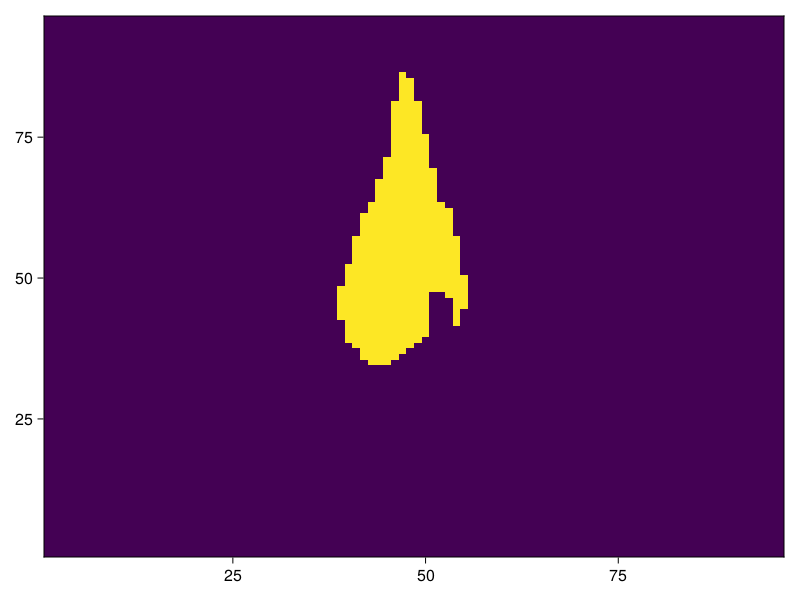

In [55]:
CairoMakie.heatmap(y1[43,:,:,1,1])

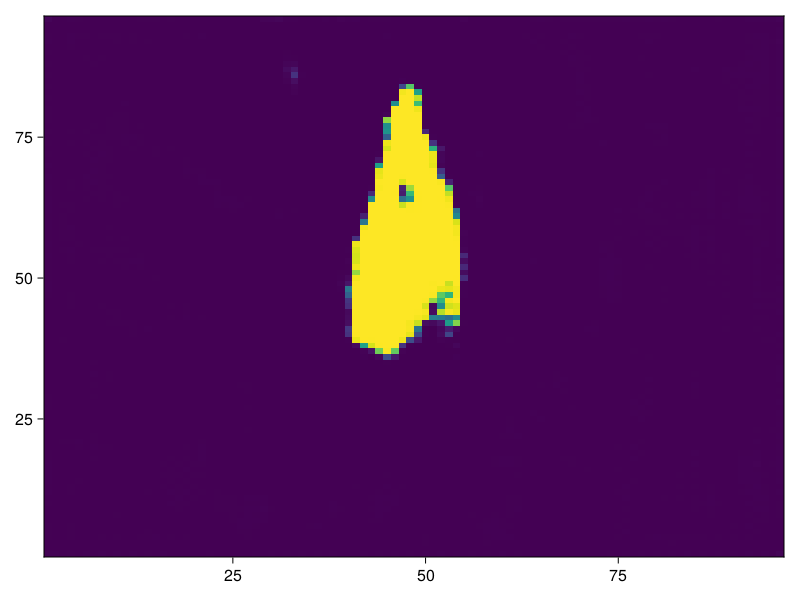

In [56]:
CairoMakie.heatmap(y_pred1[43,:,:,2,1])

## Load saved model from disk

In [29]:
task_from_disk, model_from_disk = loadtaskmodel("savedmodels/Dice_25.jld2");

## Inspect results

In [53]:
model_trained = model_from_disk |> gpu
(example1, ) = validdl
img_mask, mask_dtm = example1
x1, y1 = img_mask[1], img_mask[2] |> cpu
y_pred1 = model_trained(x1) |> cpu
chan_idx = 5;

UndefVarError: UndefVarError: model_from_disk not defined

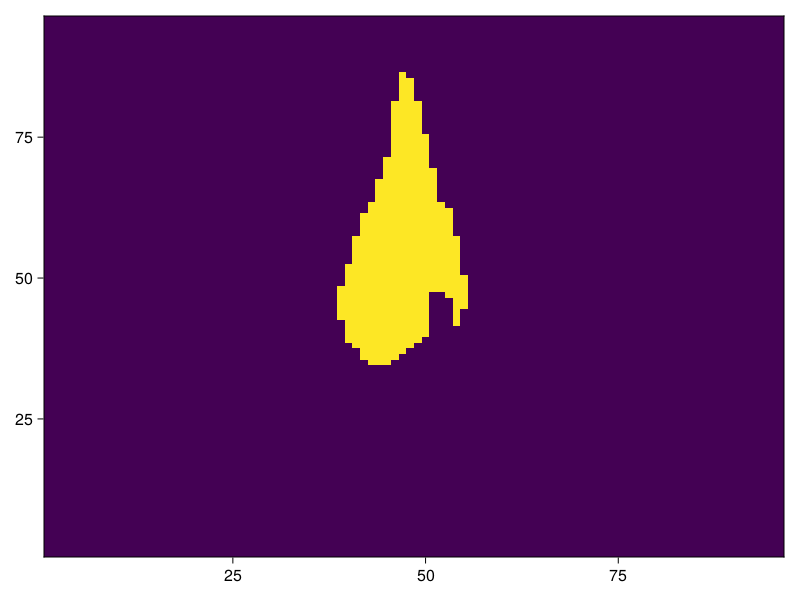

In [31]:
CairoMakie.heatmap(y1[43,:,:,1,1])

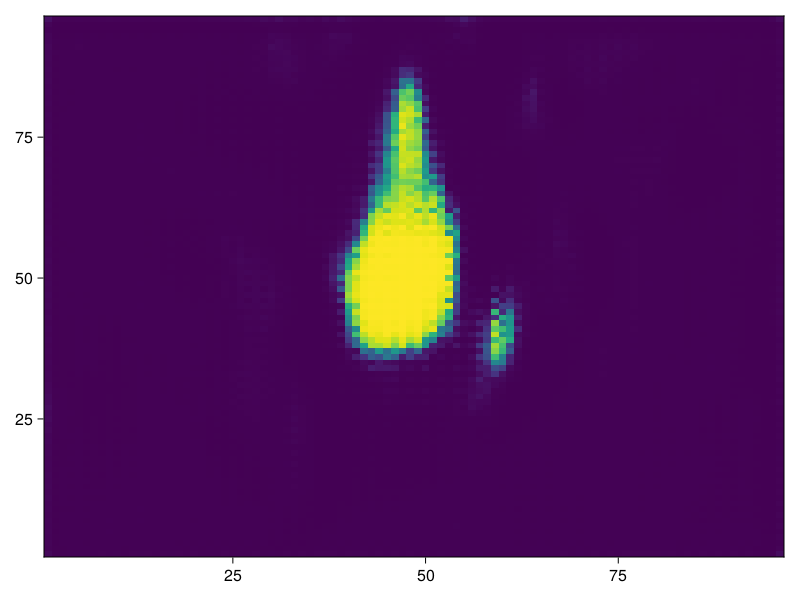

In [32]:
CairoMakie.heatmap(y_pred1[43,:,:,2,1])

# Train, Loss = Dice+HD

In [51]:
num_epochs_dice_hd = 30
epoch_times_dice_hd = []
step_times_dice_hd = []
epoch_train_losses_dice_hd = []
epoch_valid_losses_dice_hd = []
train_dice_metric_epoch_dice_hd = []
valid_dice_metric_epoch_dice_hd = []
train_hd_metric_epoch_dice_hd = []
valid_hd_metric_epoch_dice_hd = []
all_dice_metric_epoch_dice_hd = []
all_hd_metric_epoch_dice_hd = []
model2 = unet3D_new(1, 2) |> gpu
model_ps2 = Flux.params(model2)
optimizer = Adam(0.001) 
for epoch_idx = 1:num_epochs_dice_hd
    # curr_time_epoch, curr_times_step, curr_train_losses, curr_valid_losses, curr_train_dice, curr_train_hd, curr_all_dice, 
    # curr_valid_dice, curr_valid_hd, curr_all_hd = train_1_epoch_with_DICE_and_HD!(epoch_idx, model2, model_ps2, traindl, validdl, optimizer)
    curr_time_epoch, curr_times_step, curr_train_losses, curr_valid_losses =
    train_1_epoch_with_DICE_and_HD!(epoch_idx, model2, model_ps2, traindl, validdl, optimizer)
    
    # Record data
    push!(epoch_times_dice_hd, curr_time_epoch)
    for i in curr_times_step
        push!(step_times_dice_hd, i)
    end
    push!(epoch_train_losses_dice_hd, curr_train_losses)
    push!(epoch_valid_losses_dice_hd, curr_valid_losses)
    # push!(train_dice_metric_epoch_dice_hd, curr_train_dice)
    # push!(valid_dice_metric_epoch_dice_hd, curr_valid_dice)
    # push!(train_hd_metric_epoch_dice_hd, curr_train_hd)
    # push!(valid_hd_metric_epoch_dice_hd, curr_valid_hd)
    # push!(all_dice_metric_epoch_dice_hd, curr_all_dice)
    # push!(all_hd_metric_epoch_dice_hd, curr_all_hd)
    # if epoch_idx % 25 == 0
    #     #save model
    #     savetaskmodel(string("savedmodels/Dice_HD_", epoch_idx, ".jld2"), task, model2, force = true) # saving as cpu model
    # end
end

Epoch #1...

	Finished 4 steps --> Train loss = 1.2868733, Valid loss = 1.2935271


Epoch #2...


	Finished 4 steps --> Train loss = 1.3732244, Valid loss = 1.3819201


Epoch #3...


	Finished 4 steps --> Train loss = 1.3065536, Valid loss = 1.3104681


Epoch #4...


	Finished 4 steps --> Train loss = 1.1033342, Valid loss = 1.1080294


Epoch #5...


	Finished 4 steps --> Train loss = 0.7727181, Valid loss = 0.7725904


Epoch #6...


	Finished 4 steps --> Train loss = 0.468644, Valid loss = 0.46272948


Epoch #7...


	Finished 4 steps --> Train loss = 0.38132516, Valid loss = 0.37080112


Epoch #8...


	Finished 4 steps --> Train loss = 0.25890604, Valid loss = 0.22381021


Epoch #9...


	Finished 4 steps --> Train loss = 0.43340802, Valid loss = 0.3855308


Epoch #10...


	Finished 4 steps --> Train loss = 0.21050546, Valid loss = 0.21145721


Epoch #11...


	Finished 4 steps --> Train loss = 0.1928979, Valid loss = 0.17806037


Epoch #12...

	Finished 4 steps --> Train loss = 0.32455605, Valid loss = 0.2917272


Epoch #13...


	Finished 4 steps --> Train loss = 0.1754393, Valid loss = 0.16735254


Epoch #14...


	Finished 4 steps --> Train loss = 0.14201784, Valid loss = 0.1659755


Epoch #15...


	Finished 4 steps --> Train loss = 0.150755, Valid loss = 0.15685336


Epoch #16...


	Finished 4 steps --> Train loss = 0.17572263, Valid loss = 0.15714069


Epoch #17...


	Finished 4 steps --> Train loss = 0.16816211, Valid loss = 0.19246492


Epoch #18...


	Finished 4 steps --> Train loss = 0.12669815, Valid loss = 0.14816305


Epoch #19...


	Finished 4 steps --> Train loss = 0.11986314, Valid loss = 0.1463253


Epoch #20...


	Finished 4 steps --> Train loss = 0.18747976, Valid loss = 0.21723318


Epoch #21...


	Finished 4 steps --> Train loss = 0.11575134, Valid loss = 0.13410172


Epoch #22...


	Finished 4 steps --> Train loss = 0.10105769, Valid loss = 0.14456268


Epoch #23...


	Finished 4 steps --> Train loss = 0.099450774, Valid loss = 0.13162173


Epoch #24...


	Finished 4 steps --> Train loss = 0.11686067, Valid loss = 0.13736533


Epoch #25...


	Finished 4 steps --> Train loss = 0.09002989, Valid loss = 0.14007436


Epoch #26...


	Finished 4 steps --> Train loss = 0.0914336, Valid loss = 0.13578552


Epoch #27...


	Finished 4 steps --> Train loss = 0.094357096, Valid loss = 0.13011847


Epoch #28...


	Finished 4 steps --> Train loss = 0.09146415, Valid loss = 0.13517076


Epoch #29...


	Finished 4 steps --> Train loss = 0.08092147, Valid loss = 0.1435406


Epoch #30...


	Finished 4 steps --> Train loss = 0.0865058, Valid loss = 0.1274826


In [56]:
for epoch_idx = num_epochs_dice_hd+1 : 250
    # curr_time_epoch, curr_times_step, curr_train_losses, curr_valid_losses, curr_train_dice, curr_train_hd, curr_all_dice, 
    # curr_valid_dice, curr_valid_hd, curr_all_hd = train_1_epoch_with_DICE_and_HD!(epoch_idx, model2, model_ps2, traindl, validdl, optimizer)
    curr_time_epoch, curr_times_step, curr_train_losses, curr_valid_losses =
    train_1_epoch_with_DICE_and_HD!(epoch_idx, model2, model_ps2, traindl, validdl, optimizer)
    
    # Record data
    push!(epoch_times_dice_hd, curr_time_epoch)
    for i in curr_times_step
        push!(step_times_dice_hd, i)
    end
    push!(epoch_train_losses_dice_hd, curr_train_losses)
    push!(epoch_valid_losses_dice_hd, curr_valid_losses)
    # push!(train_dice_metric_epoch_dice_hd, curr_train_dice)
    # push!(valid_dice_metric_epoch_dice_hd, curr_valid_dice)
    # push!(train_hd_metric_epoch_dice_hd, curr_train_hd)
    # push!(valid_hd_metric_epoch_dice_hd, curr_valid_hd)
    # push!(all_dice_metric_epoch_dice_hd, curr_all_dice)
    # push!(all_hd_metric_epoch_dice_hd, curr_all_hd)
    # if epoch_idx % 25 == 0
    #     #save model
    #     savetaskmodel(string("savedmodels/Dice_HD_", epoch_idx, ".jld2"), task, model2, force = true) # saving as cpu model
    # end
end

Epoch #31...


	Finished 4 steps --> Train loss = 0.078799255, Valid loss = 0.11661805


Epoch #32...

	Finished 4 steps --> Train loss = 0.1025033, Valid loss = 0.17401455


Epoch #33...


	Finished 4 steps --> Train loss = 0.09508128, Valid loss = 0.13422167


Epoch #34...


	Finished 4 steps --> Train loss = 0.088401064, Valid loss = 0.13430265


Epoch #35...


	Finished 4 steps --> Train loss = 0.089860424, Valid loss = 0.13752995


Epoch #36...


	Finished 4 steps --> Train loss = 0.07274474, Valid loss = 0.12901036


Epoch #37...


	Finished 4 steps --> Train loss = 0.09026569, Valid loss = 0.1350077


Epoch #38...


	Finished 4 steps --> Train loss = 0.09330239, Valid loss = 0.125802


Epoch #39...


	Finished 4 steps --> Train loss = 0.0675874, Valid loss = 0.13199575


Epoch #40...


	Finished 4 steps --> Train loss = 0.07999539, Valid loss = 0.14252764


Epoch #41...

	Finished 4 steps --> Train loss = 0.08097537, Valid loss = 0.12511162


Epoch #42...


	Finished 4 steps --> Train loss = 0.096460566, Valid loss = 0.13741149


Epoch #43...


	Finished 4 steps --> Train loss = 0.06899989, Valid loss = 0.14163214


Epoch #44...


	Finished 4 steps --> Train loss = 0.06708348, Valid loss = 0.12879533


Epoch #45...


	Finished 4 steps --> Train loss = 0.07000455, Valid loss = 0.11861293


Epoch #46...


	Finished 4 steps --> Train loss = 0.075033195, Valid loss = 0.134984


Epoch #47...


	Finished 4 steps --> Train loss = 0.06148418, Valid loss = 0.11588784


Epoch #48...


	Finished 4 steps --> Train loss = 0.057770006, Valid loss = 0.1178076


Epoch #49...


	Finished 4 steps --> Train loss = 0.061695214, Valid loss = 0.12834457


Epoch #50...


	Finished 4 steps --> Train loss = 0.06033177, Valid loss = 0.12543789


Epoch #51...


	Finished 4 steps --> Train loss = 0.062304374, Valid loss = 0.1233555


Epoch #52...


	Finished 4 steps --> Train loss = 0.08978575, Valid loss = 0.13729158


Epoch #53...


	Finished 4 steps --> Train loss = 0.056162126, Valid loss = 0.119194545


Epoch #54...


	Finished 4 steps --> Train loss = 0.056637824, Valid loss = 0.1259237


Epoch #55...


	Finished 4 steps --> Train loss = 0.05487997, Valid loss = 0.12316519


Epoch #56...


	Finished 4 steps --> Train loss = 0.07121291, Valid loss = 0.11063227


Epoch #57...


	Finished 4 steps --> Train loss = 0.059108045, Valid loss = 0.13554394


Epoch #58...


	Finished 4 steps --> Train loss = 0.058873508, Valid loss = 0.12702166


Epoch #59...


	Finished 4 steps --> Train loss = 0.051525865, Valid loss = 0.12063251


Epoch #60...


	Finished 4 steps --> Train loss = 0.049221095, Valid loss = 0.10986381


Epoch #61...


	Finished 4 steps --> Train loss = 0.04765518, Valid loss = 0.116891615


Epoch #62...


	Finished 4 steps --> Train loss = 0.05301625, Valid loss = 0.12632515


Epoch #63...


	Finished 4 steps --> Train loss = 0.052809317, Valid loss = 0.109860085


Epoch #64...


	Finished 4 steps --> Train loss = 0.056025945, Valid loss = 0.12522289


Epoch #65...


	Finished 4 steps --> Train loss = 0.044529222, Valid loss = 0.11333


Epoch #66...


	Finished 4 steps --> Train loss = 0.050642196, Valid loss = 0.12537831


Epoch #67...


	Finished 4 steps --> Train loss = 0.05585309, Valid loss = 0.11918598


Epoch #68...


	Finished 4 steps --> Train loss = 0.042781923, Valid loss = 0.10683299


Epoch #69...


	Finished 4 steps --> Train loss = 0.049902435, Valid loss = 0.12737276


Epoch #70...


	Finished 4 steps --> Train loss = 0.041800264, Valid loss = 0.11497851


Epoch #71...


	Finished 4 steps --> Train loss = 0.045971688, Valid loss = 0.119545564


Epoch #72...


	Finished 4 steps --> Train loss = 0.049999323, Valid loss = 0.12153455


Epoch #73...


	Finished 4 steps --> Train loss = 0.038366083, Valid loss = 0.11386943


Epoch #74...


	Finished 4 steps --> Train loss = 0.052394748, Valid loss = 0.122937985


Epoch #75...


	Finished 4 steps --> Train loss = 0.04042976, Valid loss = 0.10771316


Epoch #76...


	Finished 4 steps --> Train loss = 0.03607242, Valid loss = 0.11368026


Epoch #77...


	Finished 4 steps --> Train loss = 0.038913902, Valid loss = 0.12056734


Epoch #78...


	Finished 4 steps --> Train loss = 0.04274134, Valid loss = 0.100892685


Epoch #79...


	Finished 4 steps --> Train loss = 0.0364232, Valid loss = 0.12359795


Epoch #80...


	Finished 4 steps --> Train loss = 0.04956431, Valid loss = 0.12756392


Epoch #81...


	Finished 4 steps --> Train loss = 0.037841838, Valid loss = 0.11127955


Epoch #82...


	Finished 4 steps --> Train loss = 0.047709845, Valid loss = 0.11545228


Epoch #83...


	Finished 4 steps --> Train loss = 0.036000546, Valid loss = 0.11032451


Epoch #84...


	Finished 4 steps --> Train loss = 0.038029905, Valid loss = 0.12024299


Epoch #85...


	Finished 4 steps --> Train loss = 0.047052197, Valid loss = 0.110538825


Epoch #86...


	Finished 4 steps --> Train loss = 0.037809327, Valid loss = 0.11282226


Epoch #87...


	Finished 4 steps --> Train loss = 0.047380686, Valid loss = 0.12847398


Epoch #88...


	Finished 4 steps --> Train loss = 0.03914514, Valid loss = 0.11017847


Epoch #89...


	Finished 4 steps --> Train loss = 0.035428897, Valid loss = 0.11387514


Epoch #90...


	Finished 4 steps --> Train loss = 0.048529096, Valid loss = 0.11658017


Epoch #91...


	Finished 4 steps --> Train loss = 0.03503929, Valid loss = 0.107642435


Epoch #92...


	Finished 4 steps --> Train loss = 0.03543847, Valid loss = 0.11060428


Epoch #93...


	Finished 4 steps --> Train loss = 0.03994632, Valid loss = 0.11244492


Epoch #94...


	Finished 4 steps --> Train loss = 0.037094604, Valid loss = 0.110663936


Epoch #95...


	Finished 4 steps --> Train loss = 0.029253189, Valid loss = 0.10547585


Epoch #96...


	Finished 4 steps --> Train loss = 0.031112198, Valid loss = 0.10619933


Epoch #97...


	Finished 4 steps --> Train loss = 0.0317601, Valid loss = 0.10723574


Epoch #98...


	Finished 4 steps --> Train loss = 0.029037066, Valid loss = 0.10872521


Epoch #99...


	Finished 4 steps --> Train loss = 0.030411873, Valid loss = 0.111311585


Epoch #100...


	Finished 4 steps --> Train loss = 0.0291727, Valid loss = 0.103268586


Epoch #101...


	Finished 4 steps --> Train loss = 0.03134773, Valid loss = 0.11204239


Epoch #102...


	Finished 4 steps --> Train loss = 0.037814017, Valid loss = 0.11962338


Epoch #103...


	Finished 4 steps --> Train loss = 0.031297326, Valid loss = 0.11084666


Epoch #104...


	Finished 4 steps --> Train loss = 0.035210207, Valid loss = 0.1123804


Epoch #105...


	Finished 4 steps --> Train loss = 0.027541425, Valid loss = 0.10968179


Epoch #106...


	Finished 4 steps --> Train loss = 0.03418662, Valid loss = 0.11420396


Epoch #107...


	Finished 4 steps --> Train loss = 0.029654257, Valid loss = 0.105814844


Epoch #108...


	Finished 4 steps --> Train loss = 0.025280757, Valid loss = 0.1047388


Epoch #109...


	Finished 4 steps --> Train loss = 0.034433067, Valid loss = 0.12344934


Epoch #110...


	Finished 4 steps --> Train loss = 0.03264477, Valid loss = 0.10418379


Epoch #111...


	Finished 4 steps --> Train loss = 0.02782027, Valid loss = 0.11160852


Epoch #112...


	Finished 4 steps --> Train loss = 0.031468518, Valid loss = 0.11758122


Epoch #113...


	Finished 4 steps --> Train loss = 0.026048372, Valid loss = 0.10473599


Epoch #114...


	Finished 4 steps --> Train loss = 0.028277297, Valid loss = 0.11133424


Epoch #115...


	Finished 4 steps --> Train loss = 0.046691105, Valid loss = 0.128396


Epoch #116...


	Finished 4 steps --> Train loss = 0.03530981, Valid loss = 0.1107677


Epoch #117...


	Finished 4 steps --> Train loss = 0.032230083, Valid loss = 0.10864848


Epoch #118...


	Finished 4 steps --> Train loss = 0.03136521, Valid loss = 0.11695004


Epoch #119...


	Finished 4 steps --> Train loss = 0.02796648, Valid loss = 0.10962236


Epoch #120...


	Finished 4 steps --> Train loss = 0.025537835, Valid loss = 0.10815156


Epoch #121...


	Finished 4 steps --> Train loss = 0.023790663, Valid loss = 0.11067046


Epoch #122...


	Finished 4 steps --> Train loss = 0.038914546, Valid loss = 0.10773601


Epoch #123...


	Finished 4 steps --> Train loss = 0.032537613, Valid loss = 0.119541734


Epoch #124...


	Finished 4 steps --> Train loss = 0.024568118, Valid loss = 0.10978059


Epoch #125...


	Finished 4 steps --> Train loss = 0.035657775, Valid loss = 0.10376406


Epoch #126...


	Finished 4 steps --> Train loss = 0.03183787, Valid loss = 0.12384636


Epoch #127...


	Finished 4 steps --> Train loss = 0.024338301, Valid loss = 0.10357395


Epoch #128...


	Finished 4 steps --> Train loss = 0.024737682, Valid loss = 0.11130855


Epoch #129...


	Finished 4 steps --> Train loss = 0.022384627, Valid loss = 0.10507682


Epoch #130...


	Finished 4 steps --> Train loss = 0.027956456, Valid loss = 0.10746198


Epoch #131...


	Finished 4 steps --> Train loss = 0.024266195, Valid loss = 0.1078666


Epoch #132...


	Finished 4 steps --> Train loss = 0.020758187, Valid loss = 0.10242961


Epoch #133...


	Finished 4 steps --> Train loss = 0.020064466, Valid loss = 0.110169634


Epoch #134...


	Finished 4 steps --> Train loss = 0.020968357, Valid loss = 0.10396836


Epoch #135...


	Finished 4 steps --> Train loss = 0.022814248, Valid loss = 0.11014658


Epoch #136...


	Finished 4 steps --> Train loss = 0.022622425, Valid loss = 0.10541885


Epoch #137...


	Finished 4 steps --> Train loss = 0.019815026, Valid loss = 0.109204486


Epoch #138...


	Finished 4 steps --> Train loss = 0.020524163, Valid loss = 0.10576679


Epoch #139...


	Finished 4 steps --> Train loss = 0.01858775, Valid loss = 0.105417974


Epoch #140...


	Finished 4 steps --> Train loss = 0.020465327, Valid loss = 0.1093723


Epoch #141...


	Finished 4 steps --> Train loss = 0.01898199, Valid loss = 0.10355588


Epoch #142...


	Finished 4 steps --> Train loss = 0.017636068, Valid loss = 0.10765608


Epoch #143...


	Finished 4 steps --> Train loss = 0.020044973, Valid loss = 0.107322104


Epoch #144...


	Finished 4 steps --> Train loss = 0.017159458, Valid loss = 0.10531335


Epoch #145...


	Finished 4 steps --> Train loss = 0.017465577, Valid loss = 0.10734598


Epoch #146...


	Finished 4 steps --> Train loss = 0.017490927, Valid loss = 0.10540228


Epoch #147...


	Finished 4 steps --> Train loss = 0.016712638, Valid loss = 0.10800396


Epoch #148...


	Finished 4 steps --> Train loss = 0.01746153, Valid loss = 0.10377899


Epoch #149...


	Finished 4 steps --> Train loss = 0.01677052, Valid loss = 0.105719894


Epoch #150...


	Finished 4 steps --> Train loss = 0.023430625, Valid loss = 0.11454339


Epoch #151...

	Finished 4 steps --> Train loss = 0.023231324, Valid loss = 0.10740601


Epoch #152...


	Finished 4 steps --> Train loss = 0.024453983, Valid loss = 0.10743112


Epoch #153...


	Finished 4 steps --> Train loss = 0.02266006, Valid loss = 0.10763302


Epoch #154...


	Finished 4 steps --> Train loss = 0.018945623, Valid loss = 0.107920736


Epoch #155...


	Finished 4 steps --> Train loss = 0.02035679, Valid loss = 0.1003507


Epoch #156...


	Finished 4 steps --> Train loss = 0.020195229, Valid loss = 0.110813156


Epoch #157...


	Finished 4 steps --> Train loss = 0.015828244, Valid loss = 0.10529564


Epoch #158...


	Finished 4 steps --> Train loss = 0.019165378, Valid loss = 0.097948104


Epoch #159...


	Finished 4 steps --> Train loss = 0.021506691, Valid loss = 0.11409515


Epoch #160...


	Finished 4 steps --> Train loss = 0.018343125, Valid loss = 0.10075408


Epoch #161...


	Finished 4 steps --> Train loss = 0.01589274, Valid loss = 0.10549643


Epoch #162...


	Finished 4 steps --> Train loss = 0.023513129, Valid loss = 0.109832205


Epoch #163...

	Finished 4 steps --> Train loss = 0.021743465, Valid loss = 0.10493636


Epoch #164...


	Finished 4 steps --> Train loss = 0.01518726, Valid loss = 0.10748006


Epoch #165...

	Finished 4 steps --> Train loss = 0.020161383, Valid loss = 0.10189475


Epoch #166...


	Finished 4 steps --> Train loss = 0.017472073, Valid loss = 0.105694205


Epoch #167...


	Finished 4 steps --> Train loss = 0.017122606, Valid loss = 0.10386537


Epoch #168...


	Finished 4 steps --> Train loss = 0.013741196, Valid loss = 0.107244775


Epoch #169...


	Finished 4 steps --> Train loss = 0.01393329, Valid loss = 0.101428255


Epoch #170...


	Finished 4 steps --> Train loss = 0.015983999, Valid loss = 0.10923661


Epoch #171...


	Finished 4 steps --> Train loss = 0.012645607, Valid loss = 0.10150588


Epoch #172...


	Finished 4 steps --> Train loss = 0.01181392, Valid loss = 0.10355063


Epoch #173...


	Finished 4 steps --> Train loss = 0.014009452, Valid loss = 0.10786259


Epoch #174...


	Finished 4 steps --> Train loss = 0.013279876, Valid loss = 0.100917354


Epoch #175...


	Finished 4 steps --> Train loss = 0.0122641595, Valid loss = 0.10722814


Epoch #176...


	Finished 4 steps --> Train loss = 0.01574983, Valid loss = 0.10777228


Epoch #177...


	Finished 4 steps --> Train loss = 0.012710866, Valid loss = 0.10445841


Epoch #178...


	Finished 4 steps --> Train loss = 0.012414722, Valid loss = 0.10382053


Epoch #179...


	Finished 4 steps --> Train loss = 0.0122271655, Valid loss = 0.10514895


Epoch #180...


	Finished 4 steps --> Train loss = 0.011553643, Valid loss = 0.10414014


Epoch #181...


	Finished 4 steps --> Train loss = 0.011653516, Valid loss = 0.10111717


Epoch #182...


	Finished 4 steps --> Train loss = 0.011135859, Valid loss = 0.1065857


Epoch #183...


	Finished 4 steps --> Train loss = 0.016083919, Valid loss = 0.10758773


Epoch #184...


	Finished 4 steps --> Train loss = 0.011260139, Valid loss = 0.101401135


Epoch #185...


	Finished 4 steps --> Train loss = 0.010815321, Valid loss = 0.10395847


Epoch #186...


	Finished 4 steps --> Train loss = 0.023603298, Valid loss = 0.11468382


Epoch #187...


	Finished 4 steps --> Train loss = 0.011718114, Valid loss = 0.10147412


Epoch #188...


	Finished 4 steps --> Train loss = 0.015828876, Valid loss = 0.09856174


Epoch #189...


	Finished 4 steps --> Train loss = 0.0208859, Valid loss = 0.115390345


Epoch #190...

	Finished 4 steps --> Train loss = 0.012145233, Valid loss = 0.09933726


Epoch #191...


	Finished 4 steps --> Train loss = 0.013130863, Valid loss = 0.09964316


Epoch #192...


	Finished 4 steps --> Train loss = 0.020250194, Valid loss = 0.11342565


Epoch #193...


	Finished 4 steps --> Train loss = 0.02540227, Valid loss = 0.10386034


Epoch #194...


	Finished 4 steps --> Train loss = 0.014875993, Valid loss = 0.10475319


Epoch #195...


	Finished 4 steps --> Train loss = 0.024777472, Valid loss = 0.1127591


Epoch #196...


	Finished 4 steps --> Train loss = 0.03958767, Valid loss = 0.11230842


Epoch #197...


	Finished 4 steps --> Train loss = 0.031530894, Valid loss = 0.11841496


Epoch #198...


	Finished 4 steps --> Train loss = 0.013631552, Valid loss = 0.09949516


Epoch #199...


	Finished 4 steps --> Train loss = 0.015752412, Valid loss = 0.098218456


Epoch #200...


	Finished 4 steps --> Train loss = 0.017321035, Valid loss = 0.10553919


Epoch #201...


	Finished 4 steps --> Train loss = 0.012423938, Valid loss = 0.1005518


Epoch #202...


	Finished 4 steps --> Train loss = 0.012819084, Valid loss = 0.103236645


Epoch #203...


	Finished 4 steps --> Train loss = 0.009530184, Valid loss = 0.101549156


Epoch #204...


	Finished 4 steps --> Train loss = 0.009029992, Valid loss = 0.10034691


Epoch #205...


	Finished 4 steps --> Train loss = 0.010935938, Valid loss = 0.104332626


Epoch #206...


	Finished 4 steps --> Train loss = 0.010164874, Valid loss = 0.0974631


Epoch #207...


	Finished 4 steps --> Train loss = 0.010038388, Valid loss = 0.10368799


Epoch #208...


	Finished 4 steps --> Train loss = 0.008660516, Valid loss = 0.10018163


Epoch #209...


	Finished 4 steps --> Train loss = 0.008483447, Valid loss = 0.0987111


Epoch #210...


	Finished 4 steps --> Train loss = 0.010324059, Valid loss = 0.1044726


Epoch #211...


	Finished 4 steps --> Train loss = 0.008444744, Valid loss = 0.09800814


Epoch #212...


	Finished 4 steps --> Train loss = 0.008410465, Valid loss = 0.102026775


Epoch #213...


	Finished 4 steps --> Train loss = 0.008518462, Valid loss = 0.10071071


Epoch #214...

	Finished 4 steps --> Train loss = 0.007823845, Valid loss = 0.099417895


Epoch #215...


	Finished 4 steps --> Train loss = 0.009499728, Valid loss = 0.102698825


Epoch #216...


	Finished 4 steps --> Train loss = 0.007837204, Valid loss = 0.098589


Epoch #217...


	Finished 4 steps --> Train loss = 0.007818374, Valid loss = 0.100729115


Epoch #218...


	Finished 4 steps --> Train loss = 0.008725535, Valid loss = 0.10148006


Epoch #219...


	Finished 4 steps --> Train loss = 0.007665754, Valid loss = 0.09806847


Epoch #220...


	Finished 4 steps --> Train loss = 0.008702951, Valid loss = 0.10161982


Epoch #221...


	Finished 4 steps --> Train loss = 0.007991008, Valid loss = 0.10015963


Epoch #222...


	Finished 4 steps --> Train loss = 0.0073980605, Valid loss = 0.09789881


Epoch #223...


	Finished 4 steps --> Train loss = 0.009883981, Valid loss = 0.103425406


Epoch #224...


	Finished 4 steps --> Train loss = 0.007979787, Valid loss = 0.09884045


Epoch #225...


	Finished 4 steps --> Train loss = 0.007627358, Valid loss = 0.09850105


Epoch #226...


	Finished 4 steps --> Train loss = 0.01024314, Valid loss = 0.10366049


Epoch #227...


	Finished 4 steps --> Train loss = 0.008370038, Valid loss = 0.098807566


Epoch #228...


	Finished 4 steps --> Train loss = 0.00873309, Valid loss = 0.09944057


Epoch #229...


	Finished 4 steps --> Train loss = 0.010061416, Valid loss = 0.10210888


Epoch #230...


	Finished 4 steps --> Train loss = 0.007915558, Valid loss = 0.09926698


Epoch #231...


	Finished 4 steps --> Train loss = 0.008985491, Valid loss = 0.09811438


Epoch #232...


	Finished 4 steps --> Train loss = 0.014246505, Valid loss = 0.10630893


Epoch #233...


	Finished 4 steps --> Train loss = 0.008613041, Valid loss = 0.09843898


Epoch #234...


	Finished 4 steps --> Train loss = 0.0077949865, Valid loss = 0.0993475


Epoch #235...


	Finished 4 steps --> Train loss = 0.009345461, Valid loss = 0.10376269


Epoch #236...


	Finished 4 steps --> Train loss = 0.008750786, Valid loss = 0.09445455


Epoch #237...

	Finished 4 steps --> Train loss = 0.009528579, Valid loss = 0.10401987


Epoch #238...

	Finished 4 steps --> Train loss = 0.009459599, Valid loss = 0.101783186


Epoch #239...


	Finished 4 steps --> Train loss = 0.008102341, Valid loss = 0.09823259


Epoch #240...


	Finished 4 steps --> Train loss = 0.00764395, Valid loss = 0.09856426


Epoch #241...

	Finished 4 steps --> Train loss = 0.015120971, Valid loss = 0.10742563


Epoch #242...


	Finished 4 steps --> Train loss = 0.008360421, Valid loss = 0.09794296


Epoch #243...


	Finished 4 steps --> Train loss = 0.00683859, Valid loss = 0.09774874


Epoch #244...


	Finished 4 steps --> Train loss = 0.008726604, Valid loss = 0.10281006


Epoch #245...


	Finished 4 steps --> Train loss = 0.0077564004, Valid loss = 0.09472846


Epoch #246...


	Finished 4 steps --> Train loss = 0.007687532, Valid loss = 0.100494765


Epoch #247...


	Finished 4 steps --> Train loss = 0.00760715, Valid loss = 0.10096383


Epoch #248...


	Finished 4 steps --> Train loss = 0.0075592557, Valid loss = 0.096023075


Epoch #249...


	Finished 4 steps --> Train loss = 0.011127655, Valid loss = 0.10390345


Epoch #250...


	Finished 4 steps --> Train loss = 0.0067437477, Valid loss = 0.09743241


In [408]:
mean(step_times_dice_hd[2:end])*1e-9

0.9102198798798798

In [409]:
minimum(step_times_dice_hd)*1e-9

0.30429

In [410]:
minimum(epoch_times_dice_hd)*1e-9

2.62101

In [411]:
mean(epoch_times_dice_hd[2:end])*1e-9

3.639100120481928

## Inspect results

In [74]:
# model_trained = learner1.model
model_trained = model2
(example1, ) = validdl
img_mask, mask_dtm = example1
x1, y1 = img_mask[1], img_mask[2] |> cpu
y_pred1 = model_trained(x1) |> cpu
chan_idx = 5;

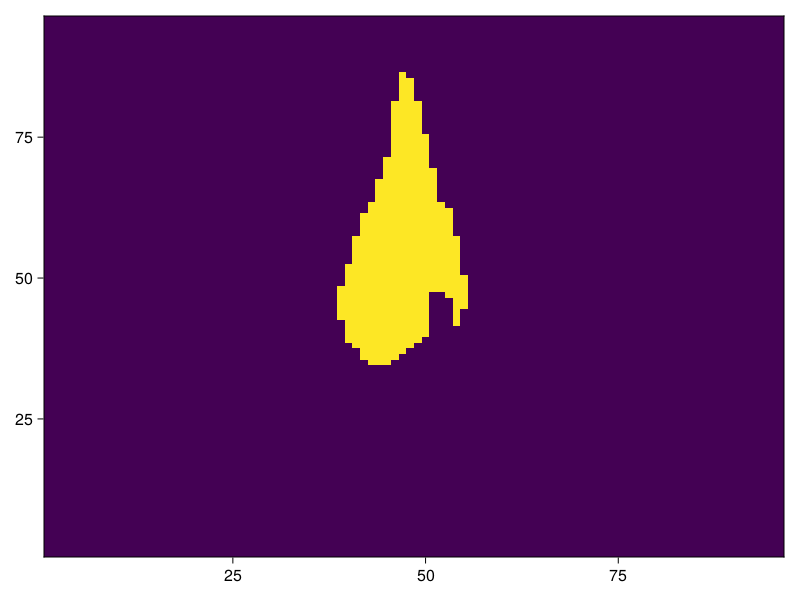

In [405]:
CairoMakie.heatmap((y1[43,:,:,1,1]))

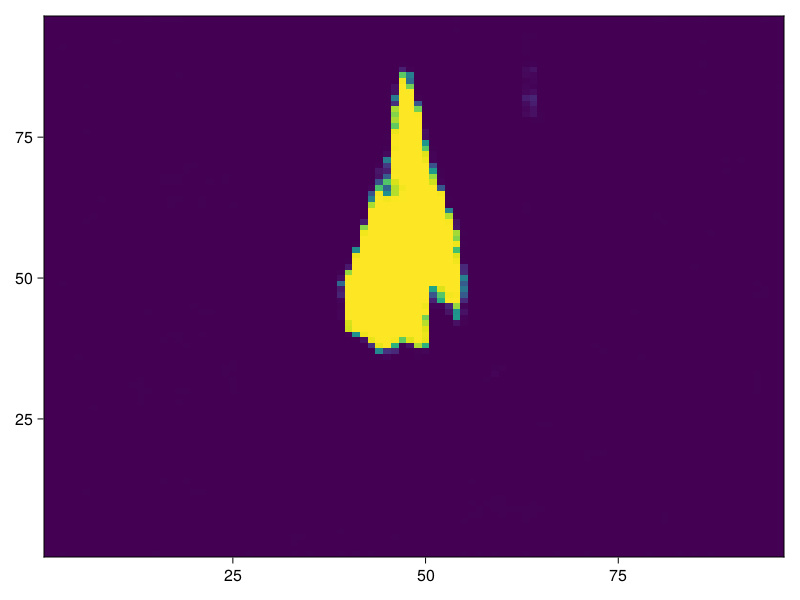

In [406]:
CairoMakie.heatmap((y_pred1[43,:,:,2,1]))

In [72]:
# save 4 data
df_epoch = DataFrame(epoch_times_dice_hd = epoch_times_dice_hd)
# df_epoch = DataFrame(epoch_times_dice = epoch_times_dice, epoch_times_dice_hd = epoch_times_dice_hd)
CSV.write("Julia_Loop_Results/Epoch_Time_Manuer.csv", df_epoch)

"Julia_Loop_Results/Epoch_Time_Manuer.csv"

In [73]:
df_step = DataFrame(step_times_dice_hd = step_times_dice_hd)
# df_step = DataFrame(step_times_dice = step_times_dice, step_times_dice_hd = step_times_dice_hd)
CSV.write("Julia_Loop_Results/Step_Time_Manuer.csv", df_step)

"Julia_Loop_Results/Step_Time_Manuer.csv"

In [32]:
df_loss = DataFrame(train_losses_dice = epoch_train_losses_dice, train_losses_dice_hd = epoch_train_losses_dice_hd, 
valid_losses_dice = epoch_valid_losses_dice, valid_losses_dice_hd = epoch_valid_losses_dice_hd)
CSV.write("Julia_Loop_Results/Julia_Loop_Loss_jan_8.csv", df_loss)

"Julia_Loop_Results/Julia_Loop_Loss_jan_8.csv"

In [33]:
df_dice_m = DataFrame(train_dice_metric_dice = train_dice_metric_epoch_dice, valid_dice_metric_dice = valid_dice_metric_epoch_dice, 
all_dice_metric_dice = all_dice_metric_epoch_dice, train_dice_metric_dice_hd = train_dice_metric_epoch_dice_hd,
valid_dice_metric_dice_hd = valid_dice_metric_epoch_dice_hd, all_dice_metric_dice_hd = all_dice_metric_epoch_dice_hd)
CSV.write("Julia_Loop_Results/Julia_Loop_Dice_Metric_jan_8.csv", df_dice_m)

"Julia_Loop_Results/Julia_Loop_Dice_Metric_jan_8.csv"

In [34]:
df_hd_m = DataFrame(train_hd_metric_dice = train_hd_metric_epoch_dice, valid_hd_metric_dice = valid_hd_metric_epoch_dice, 
all_hd_metric_dice = all_hd_metric_epoch_dice, train_hd_metric_dice_hd = train_hd_metric_epoch_dice_hd,
valid_hd_metric_dice_hd = valid_hd_metric_epoch_dice_hd, all_hd_metric_dice_hd = all_hd_metric_epoch_dice_hd)
CSV.write("Julia_Loop_Results/Julia_Loop_HD_Metric_jan_8.csv", df_hd_m)

"Julia_Loop_Results/Julia_Loop_HD_Metric_jan_8.csv"

In [35]:
size(epoch_times_dice)

(250,)